# Projet 5 - Produisez une étude de marché

## Partie I - Importation des données

### Importation des données

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import P5_03_OCR5 as OCR

from scipy.cluster.hierarchy import linkage, fcluster, cophenet, dendrogram

from sklearn import preprocessing
from sklearn import decomposition

from scipy.spatial.distance import pdist

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro
from scipy.stats import ttest_ind

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

sns.set(color_codes = True)
#sns.set(style="whitegrid")

In [2]:
_FONTSIZE_ = 18
_FONTSIZETITLE_ = 24

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}

meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

### Importation des données nettoyés

In [3]:
data = pd.read_csv('./Export/data.csv', index_col = 0)

## Partie II - Réalisation du dendrogramme

### Préparation des données - Centrage et Réduction

In [4]:
# préparation des données pour le clustering
X = data.values
names = data.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

__CLUSTER__ = 5

### Optimisation du dendrogramme

### Cophenetic correlation

Nous calculons les coefficients Cophenitiques pour chaque méthode de la fonction sklearn.linkage

In [5]:
OCR.coefCophenetic(X_scaled)

,Single,Complete,Average,Weighted,Centroid,Median,Ward
Cophenetic Coefficient,0.61,0.67,0.73,0.64,0.74,0.62,0.61


Nous constatons que la méthode Average à la meilleure corélation entre les distances du DataFrame et les distances du dendrogramme.

### Courbe de Lorenz et coefficient de Gini

Nous calculons les coefficients de Gini pour chaque méthode de la fonction sklearn.linkage

In [6]:
OCR.coefGini(X_scaled)

,Single,Complete,Average,Weighted,Centroid,Median,Ward
Gini Coefficient,0.219436,0.369594,0.305584,0.312177,0.291031,0.283927,0.484601


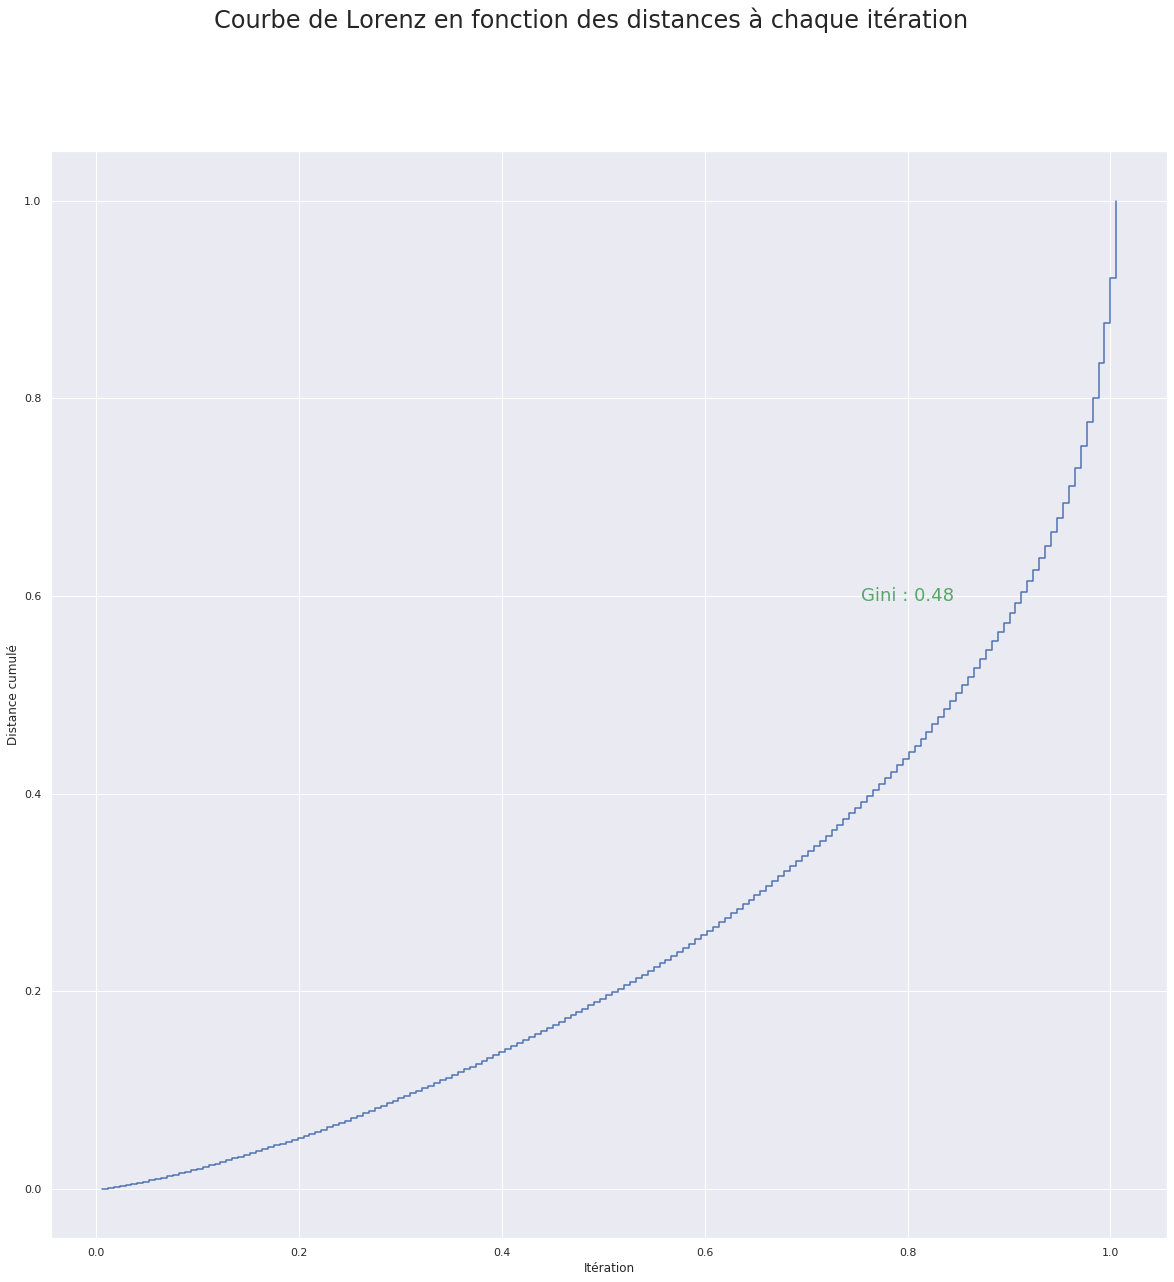

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

fig.suptitle("Courbe de Lorenz en fonction des distances à chaque itération", fontsize= _FONTSIZETITLE_)

Z = linkage(X_scaled, 'ward')
lorenz, n, gini = OCR.lorenz(pd.DataFrame(data=Z[:,2]))
xaxis = np.linspace(1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

axes.plot(xaxis,lorenz,drawstyle='steps-post')
axes.text(0.8, 0.6, f"Gini : {gini:0.2f}", {'color': 'C2', 'fontsize': 18}, va="center", ha="center")
axes.set_xlabel('Itération')
axes.set_ylabel('Distance cumulé')

plt.show()

### Coefficient de Silhouette

In [8]:
methods = ['Single', 'Complete', 'Average', 'Weighted', 'Centroid', 'Median', 'Ward']
scoreSilhouetteMethod = []

for method in methods:
    Z = linkage(X_scaled, method.lower())
    scoreSilhouette = []
    for cluster in range(2, 11):
        clusters = fcluster(Z, cluster, criterion='maxclust')
        if len(set(clusters)) > 1:
            scoreSilhouette.append(silhouette_score(X_scaled, clusters))
        else:
            scoreSilhouette.append(0)
    
    scoreSilhouetteMethod.append(scoreSilhouette)

silhouette = pd.DataFrame(scoreSilhouetteMethod, index=methods, columns=range(2,11))

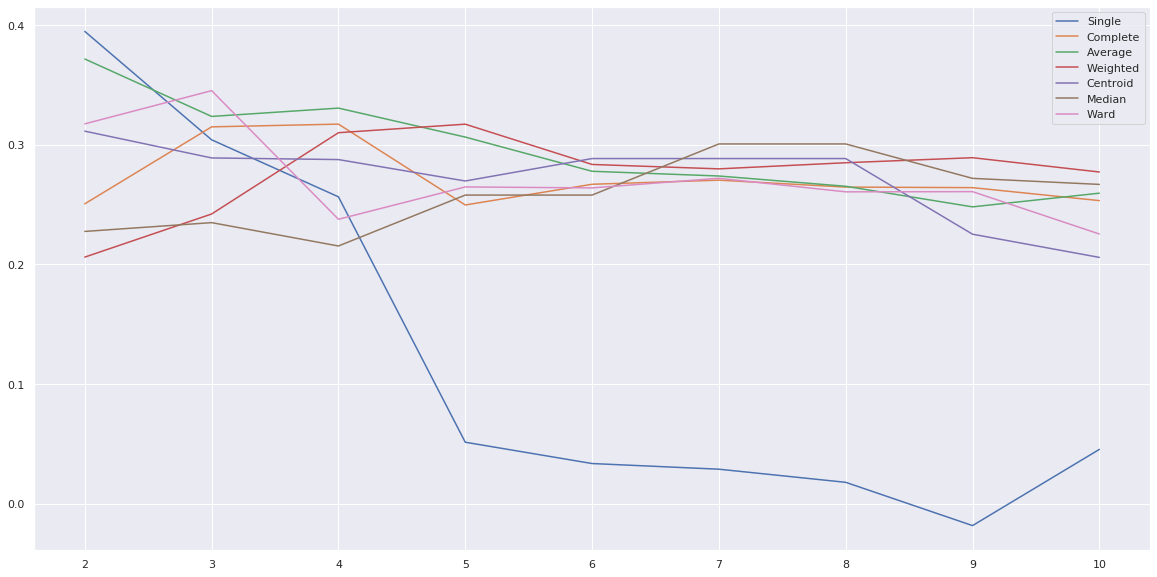

In [9]:
fig = plt.figure(figsize=(20,10))

for i in range(0,7):
    sns.lineplot(y=silhouette.iloc[i, :].values, x=silhouette.iloc[i, :].index, label=methods[i])

In [10]:
silhouette

,2,3,4,5,6,7,8,9,10
Single,0.394825,0.304198,0.256530,0.051366,0.033542,0.028809,0.017836,-0.018339,0.045364
Complete,0.250688,0.315022,0.317312,0.249714,0.267022,0.270455,0.264676,0.264208,0.253370
Average,0.371774,0.323736,0.330697,0.306481,0.277883,0.273935,0.265350,0.248130,0.259579
Weighted,0.206135,0.242170,0.310137,0.317267,0.283598,0.279903,0.285032,0.289236,0.277283
Centroid,0.311427,0.289042,0.287675,0.269764,0.288524,0.288524,0.288524,0.225280,0.205891
Median,0.227596,0.234950,0.215426,0.257990,0.257990,0.300739,0.300739,0.271961,0.266907
Ward,0.317535,0.345291,0.237754,0.264802,0.263984,0.272034,0.260688,0.260866,0.225451


Nous constatons que les données, au delà de 2 clusters, commence à presenter une superposition des clusters de plus en plus importantes. Pour la méthode centroide, nous obtenons un meilleur résultat pour 3 clusters uniquement du fait que pour la division en deux clusters, un seul cluster est selectionné.

## Partie III - Analyse exploratoire

Nous allons faire une analyse exploratoire des 4 variables en fonction des 5 clusters sélectionnés afin de determiner et d'analyser les caractéristiques de selection des clusters

In [11]:
Z = linkage(X_scaled, 'ward')
clusters = fcluster(Z, __CLUSTER__, criterion='maxclust')

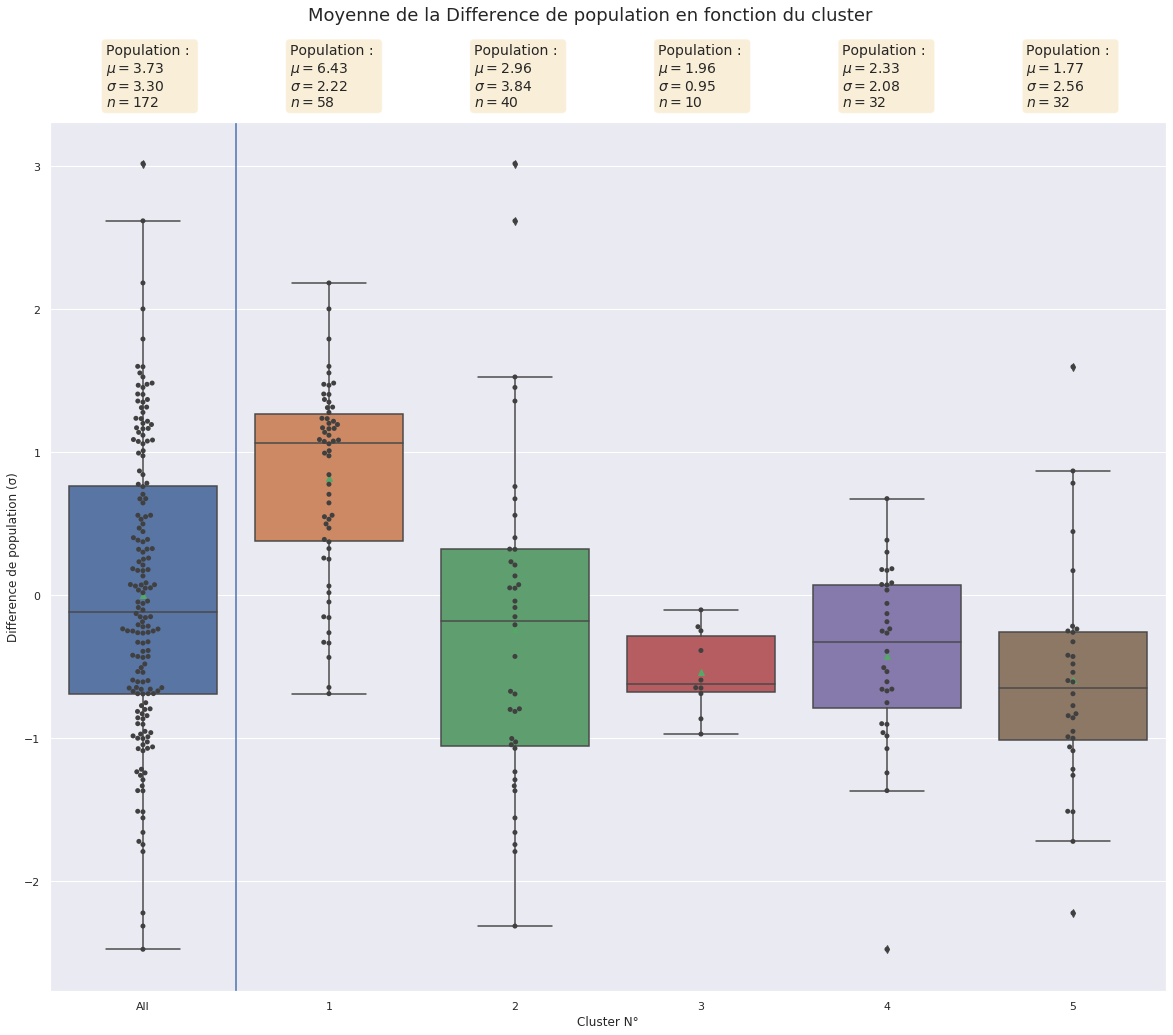

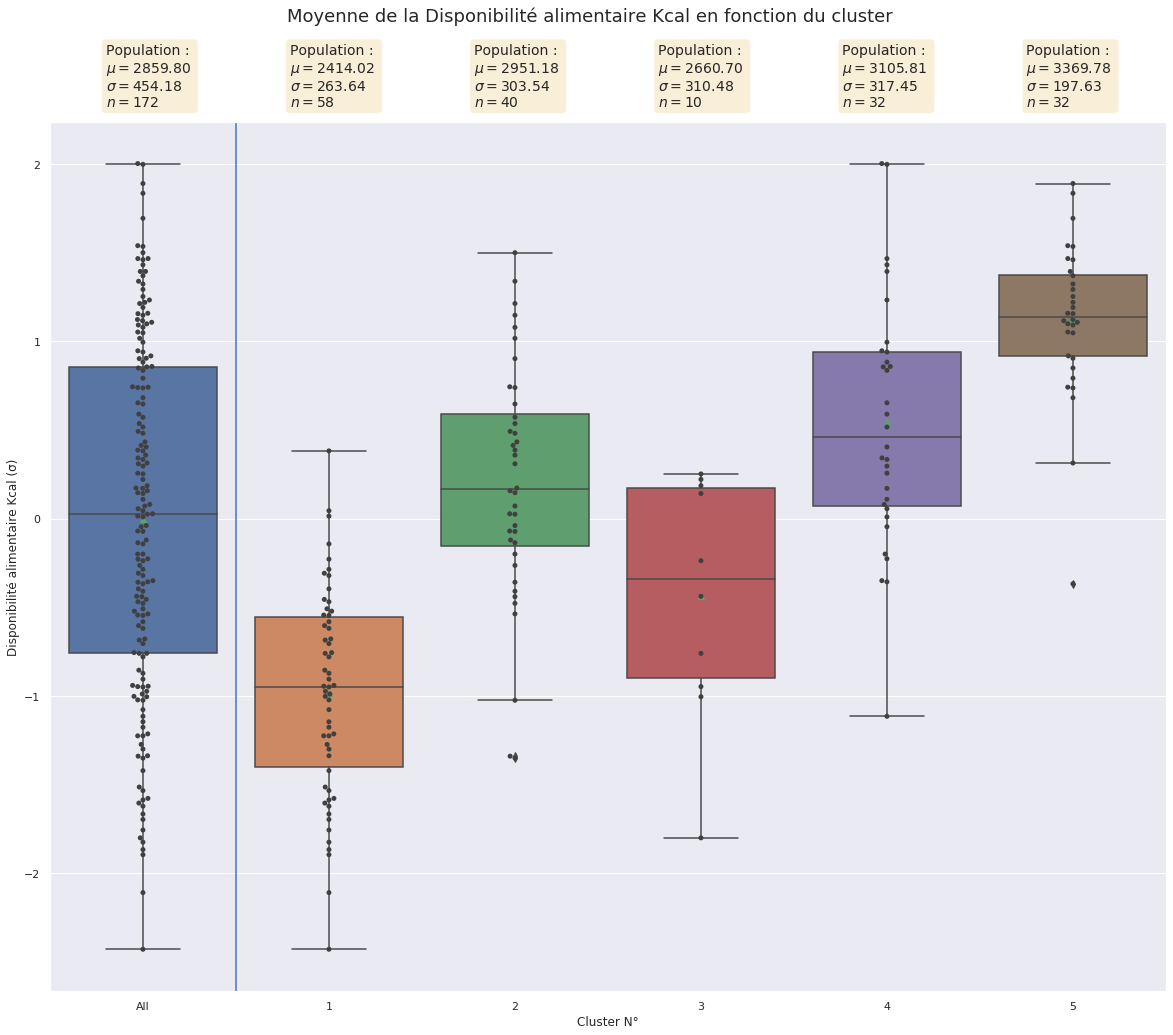

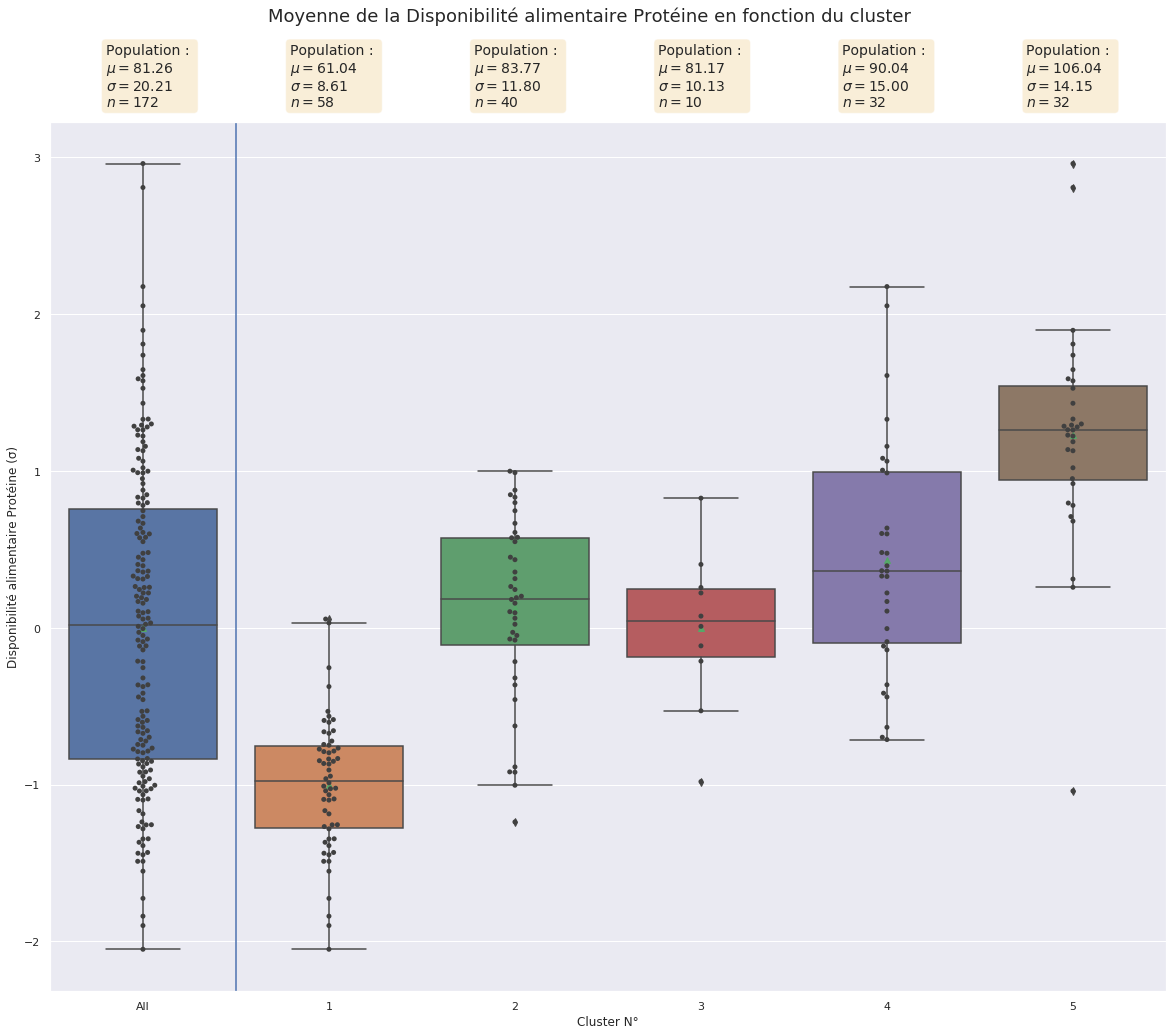

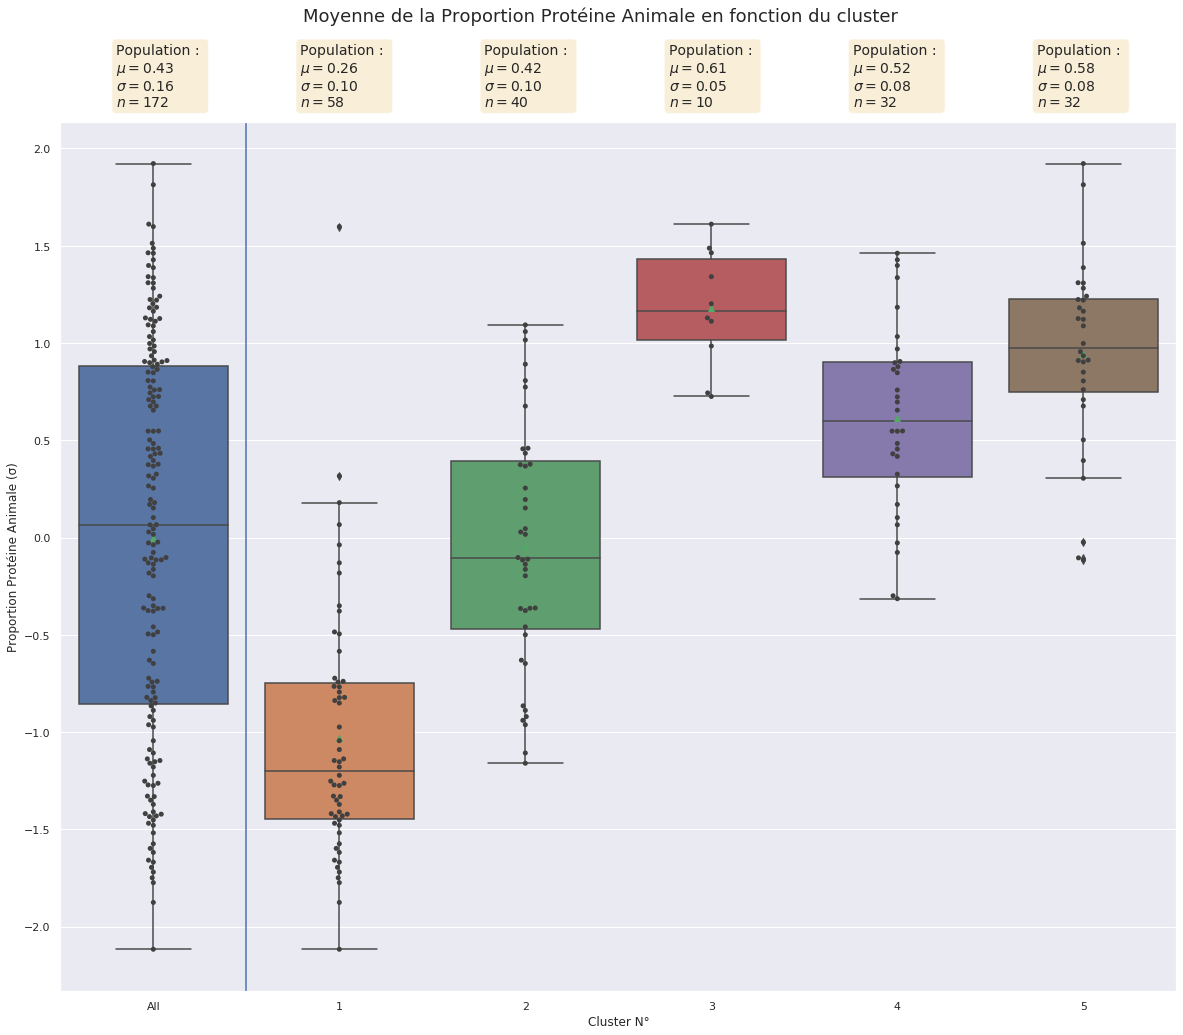

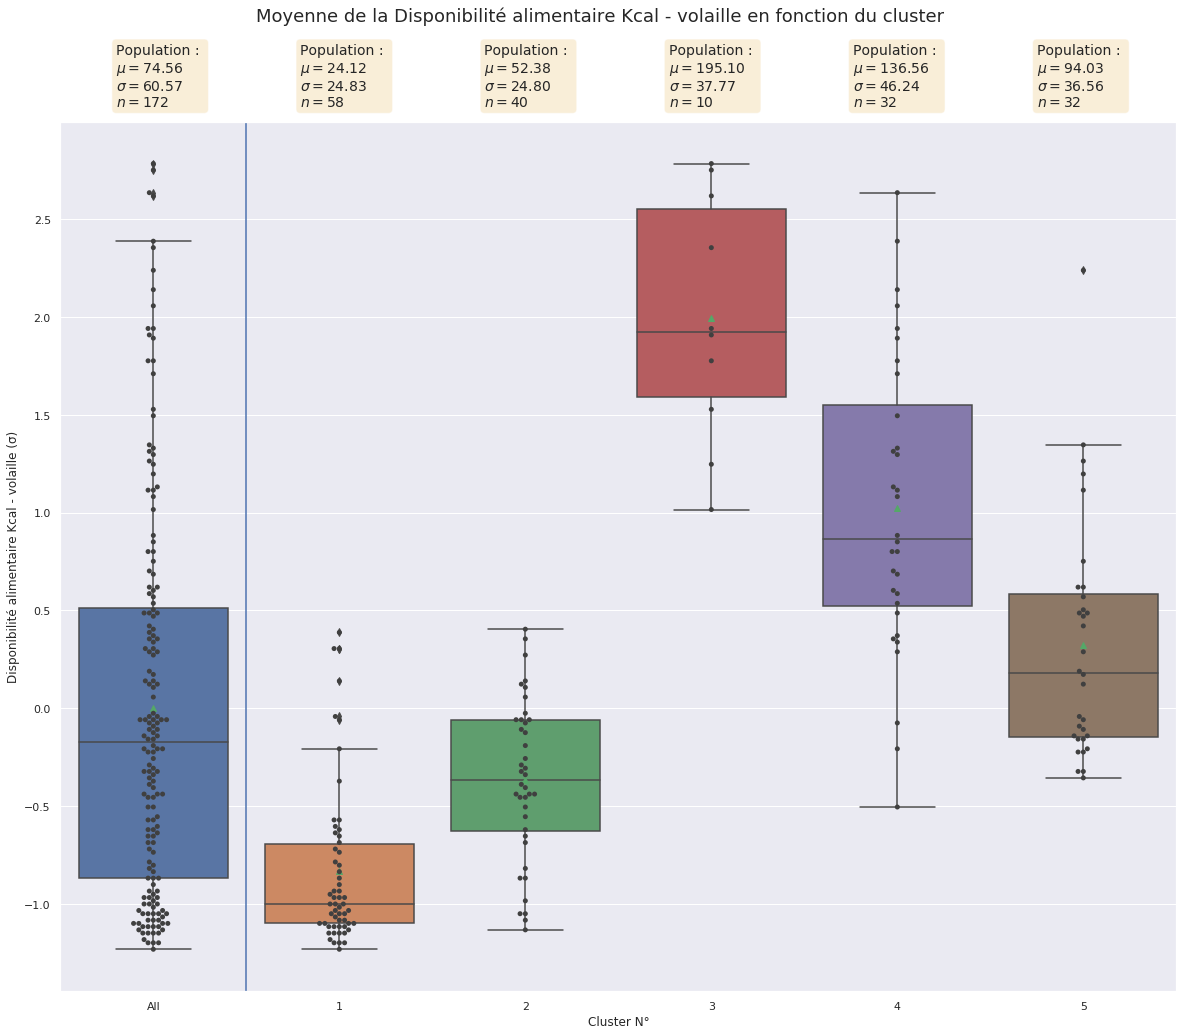

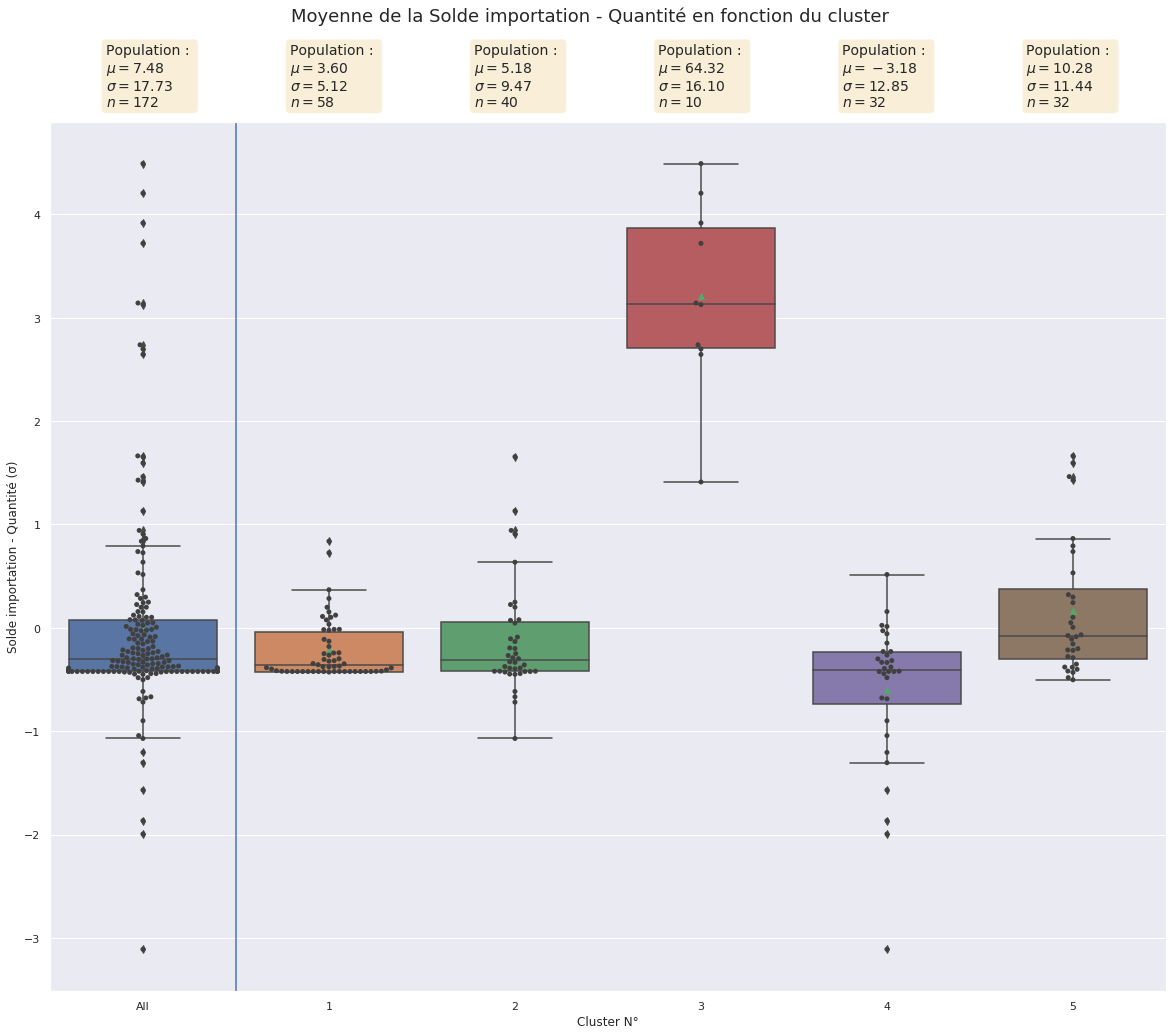

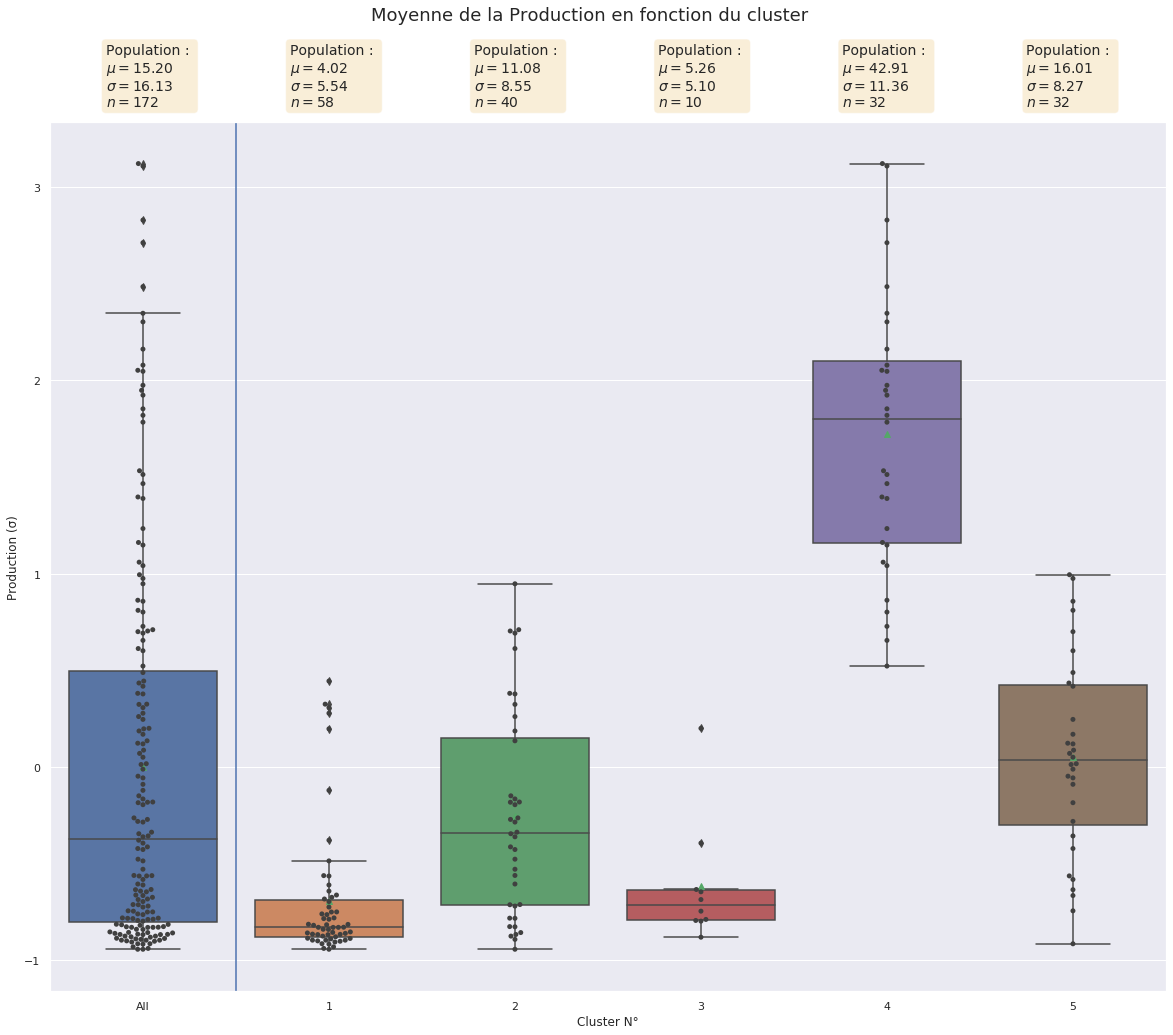

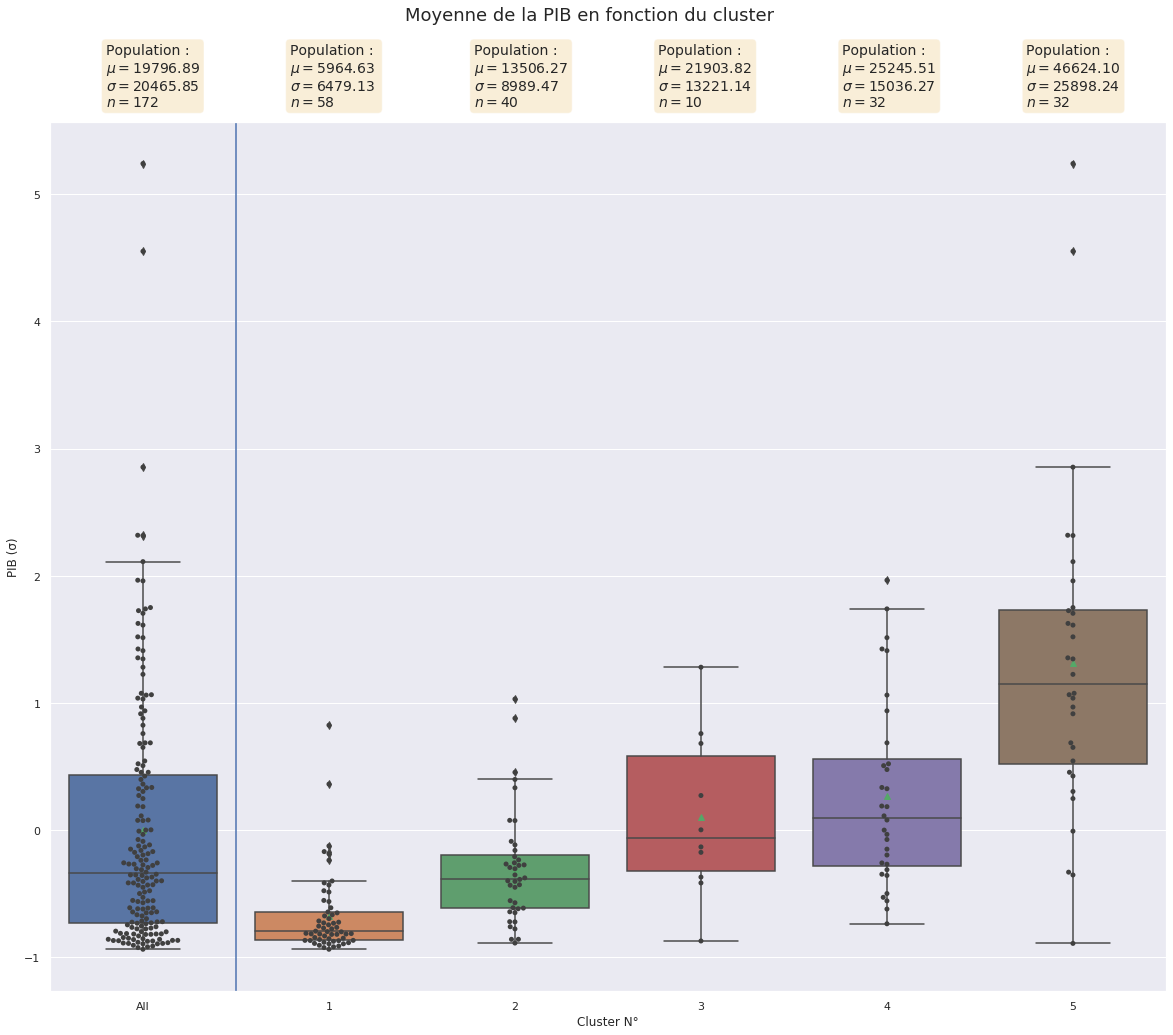

In [12]:
OCR.plotbox(data, clusters)

* La méthode **simple** constitue 1 cluster avec la quasi totalité des individus, un cluster avec 2 individus et 3 clusters avec chaque 1 individu.
* La méthode **complete** constitue 3 clusters avec plus de 10 individues et 2 clusters avec moins de 10 individus.
* La méthode **average** ne forme que deux clusters conséquents, 1 clusters de 10 individus et 2 clusters contenant des individus uniques.
* La méthode **weighted** ne forme que deux clusters conséquents, 1 clusters de 22 individus, 1 clusters de 10 et 1 clusters contenant que 2 individus.
* La méthode **centroid** constitue 1 cluster avec la quasi totalité des individus, un cluster avec 9 individu, un cluster avec 2 individus et 2 clusters avec chaque 1 individu.
* La méthode **median** constitue 1 cluster avec la quasi totalité des individus et 4 clusters avec moins de 10 individus.
* La méthode **ward** constitue 4 clusters avec plus de 10 individues et 1 cluster avec moins de 10 individus.

Nous choississons la méthode ward qui donne un partage en clusters le plus équilibré

### Caractérisation des variables par paires

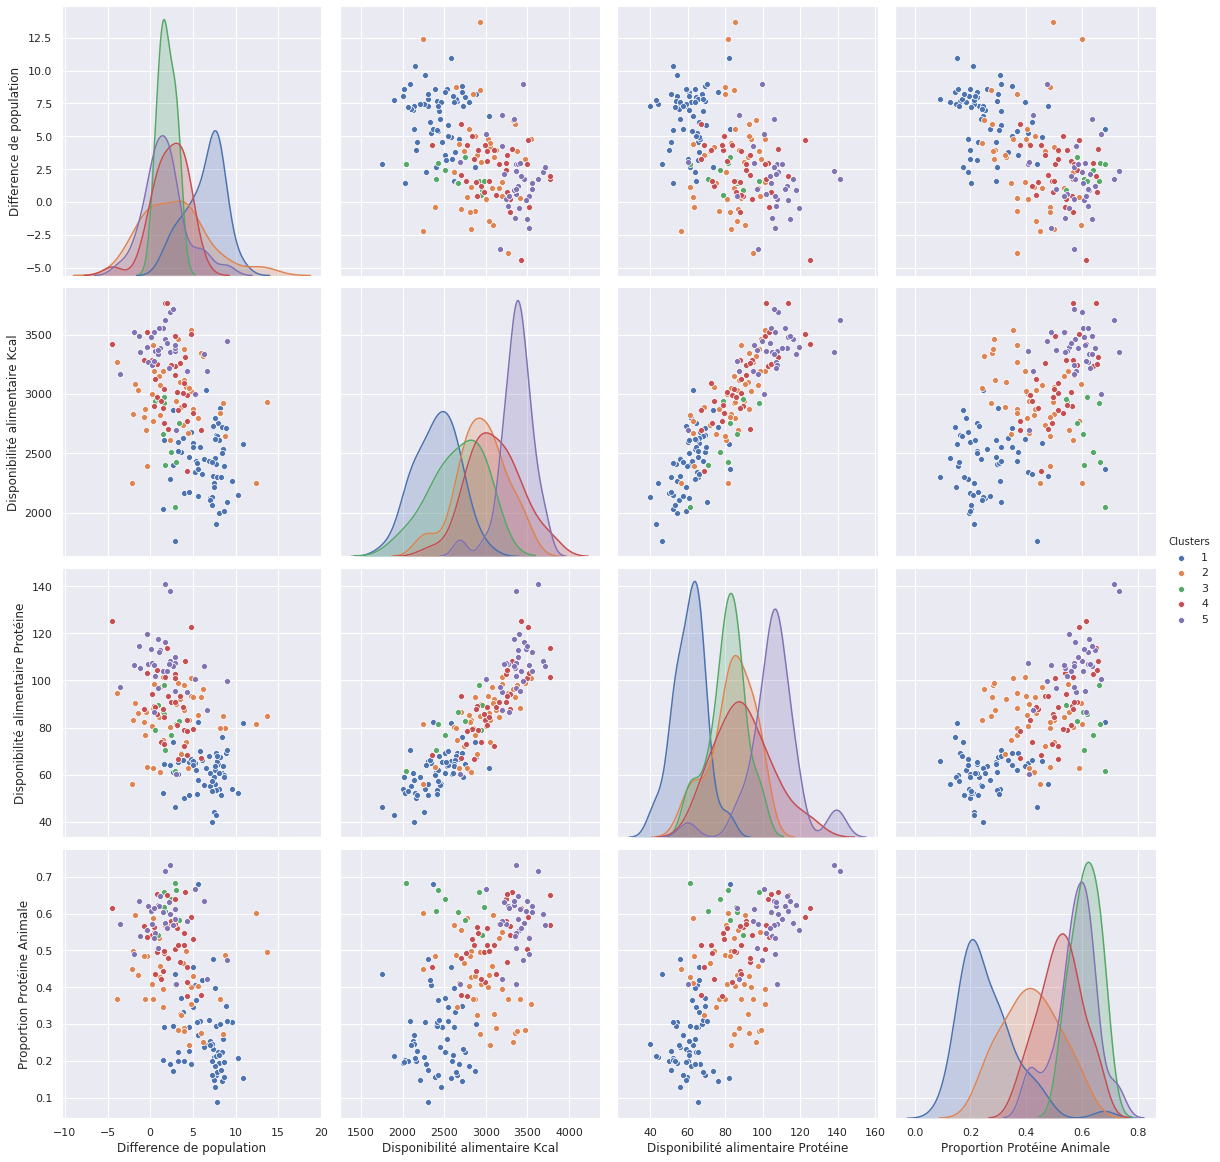

In [13]:
df = pd.DataFrame(data=X)
df.columns =  ['Difference de population', 'Disponibilité alimentaire Kcal', 'Disponibilité alimentaire Protéine', 'Proportion Protéine Animale', 'Disponibilité alimentaire Kcal - volaille', 'Solde importation - Quantité', 'Production', 'PIB']
df['Clusters'] = fcluster(Z, __CLUSTER__, criterion='maxclust')
sns.pairplot(df[['Difference de population', 'Disponibilité alimentaire Kcal', 'Disponibilité alimentaire Protéine', 'Proportion Protéine Animale', 'Clusters']], hue='Clusters', height=4)

plt.savefig('Images/carac_paires.png')

### Dendrogramme

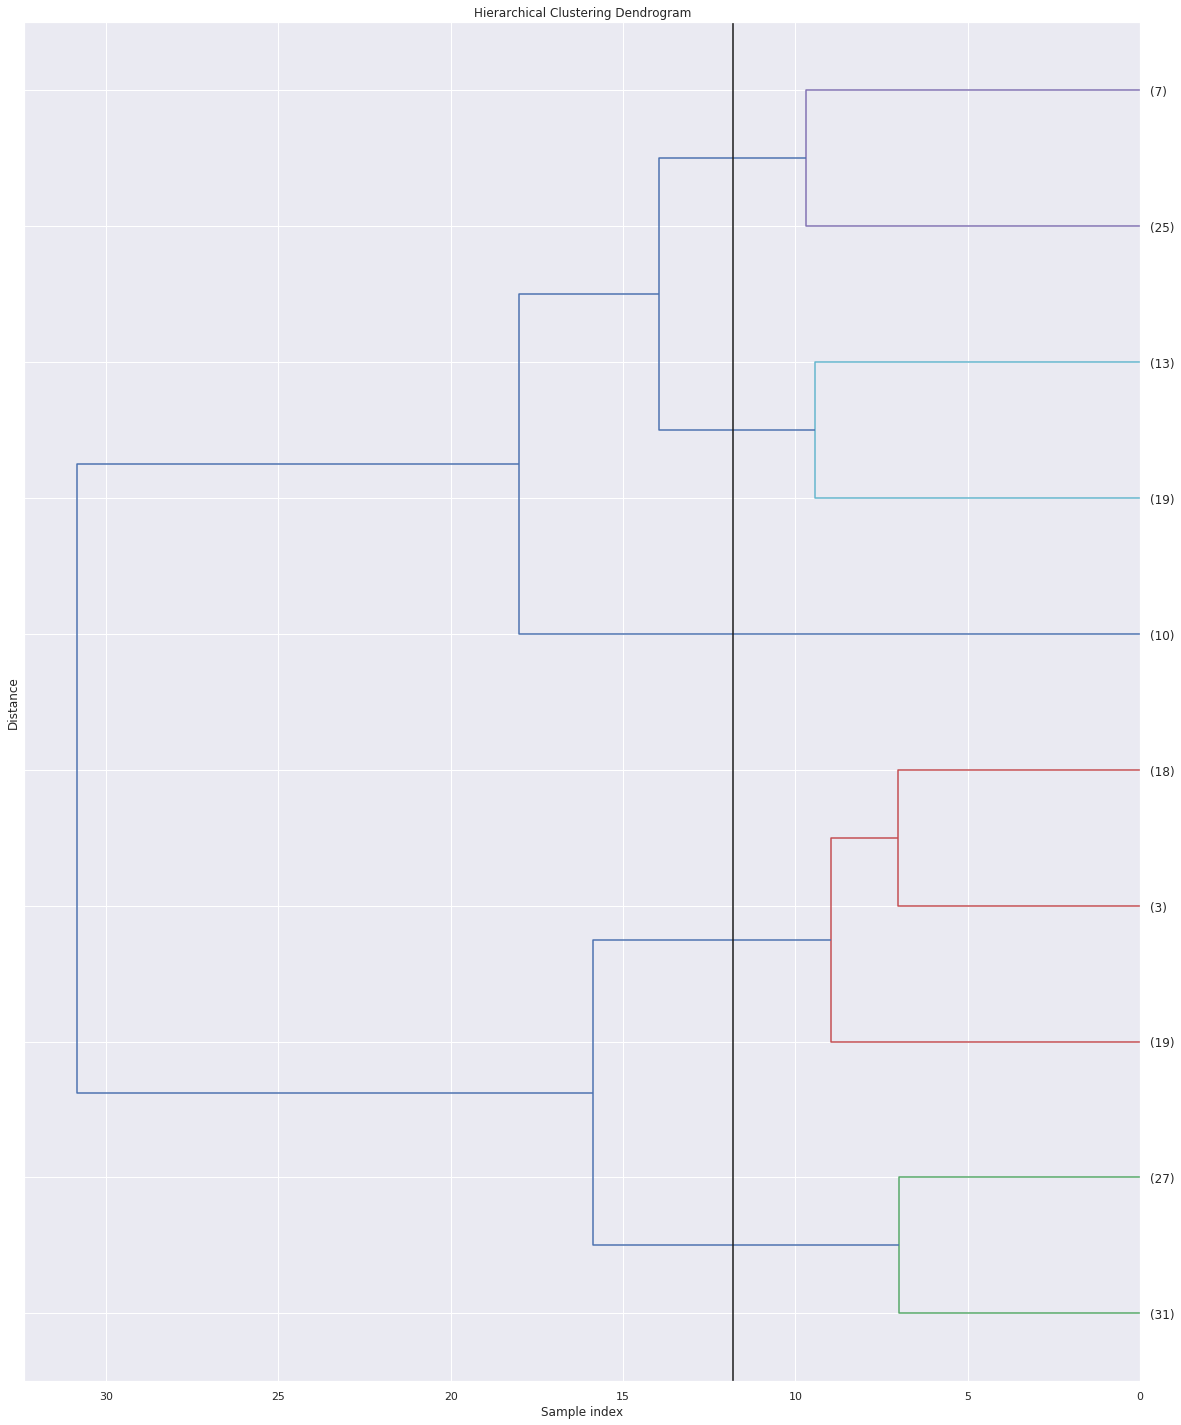

In [14]:
# Affichage du dendrogramme tronqué

x = Z[-__CLUSTER__][2] + (Z[-__CLUSTER__+1][2] - Z[-__CLUSTER__][2]) / 2

plt.figure(figsize=(20,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axvline(x, c='k')
dendrogram(
    Z,
    labels = names,
    orientation = "left",
    color_threshold = x,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10
)
plt.show()

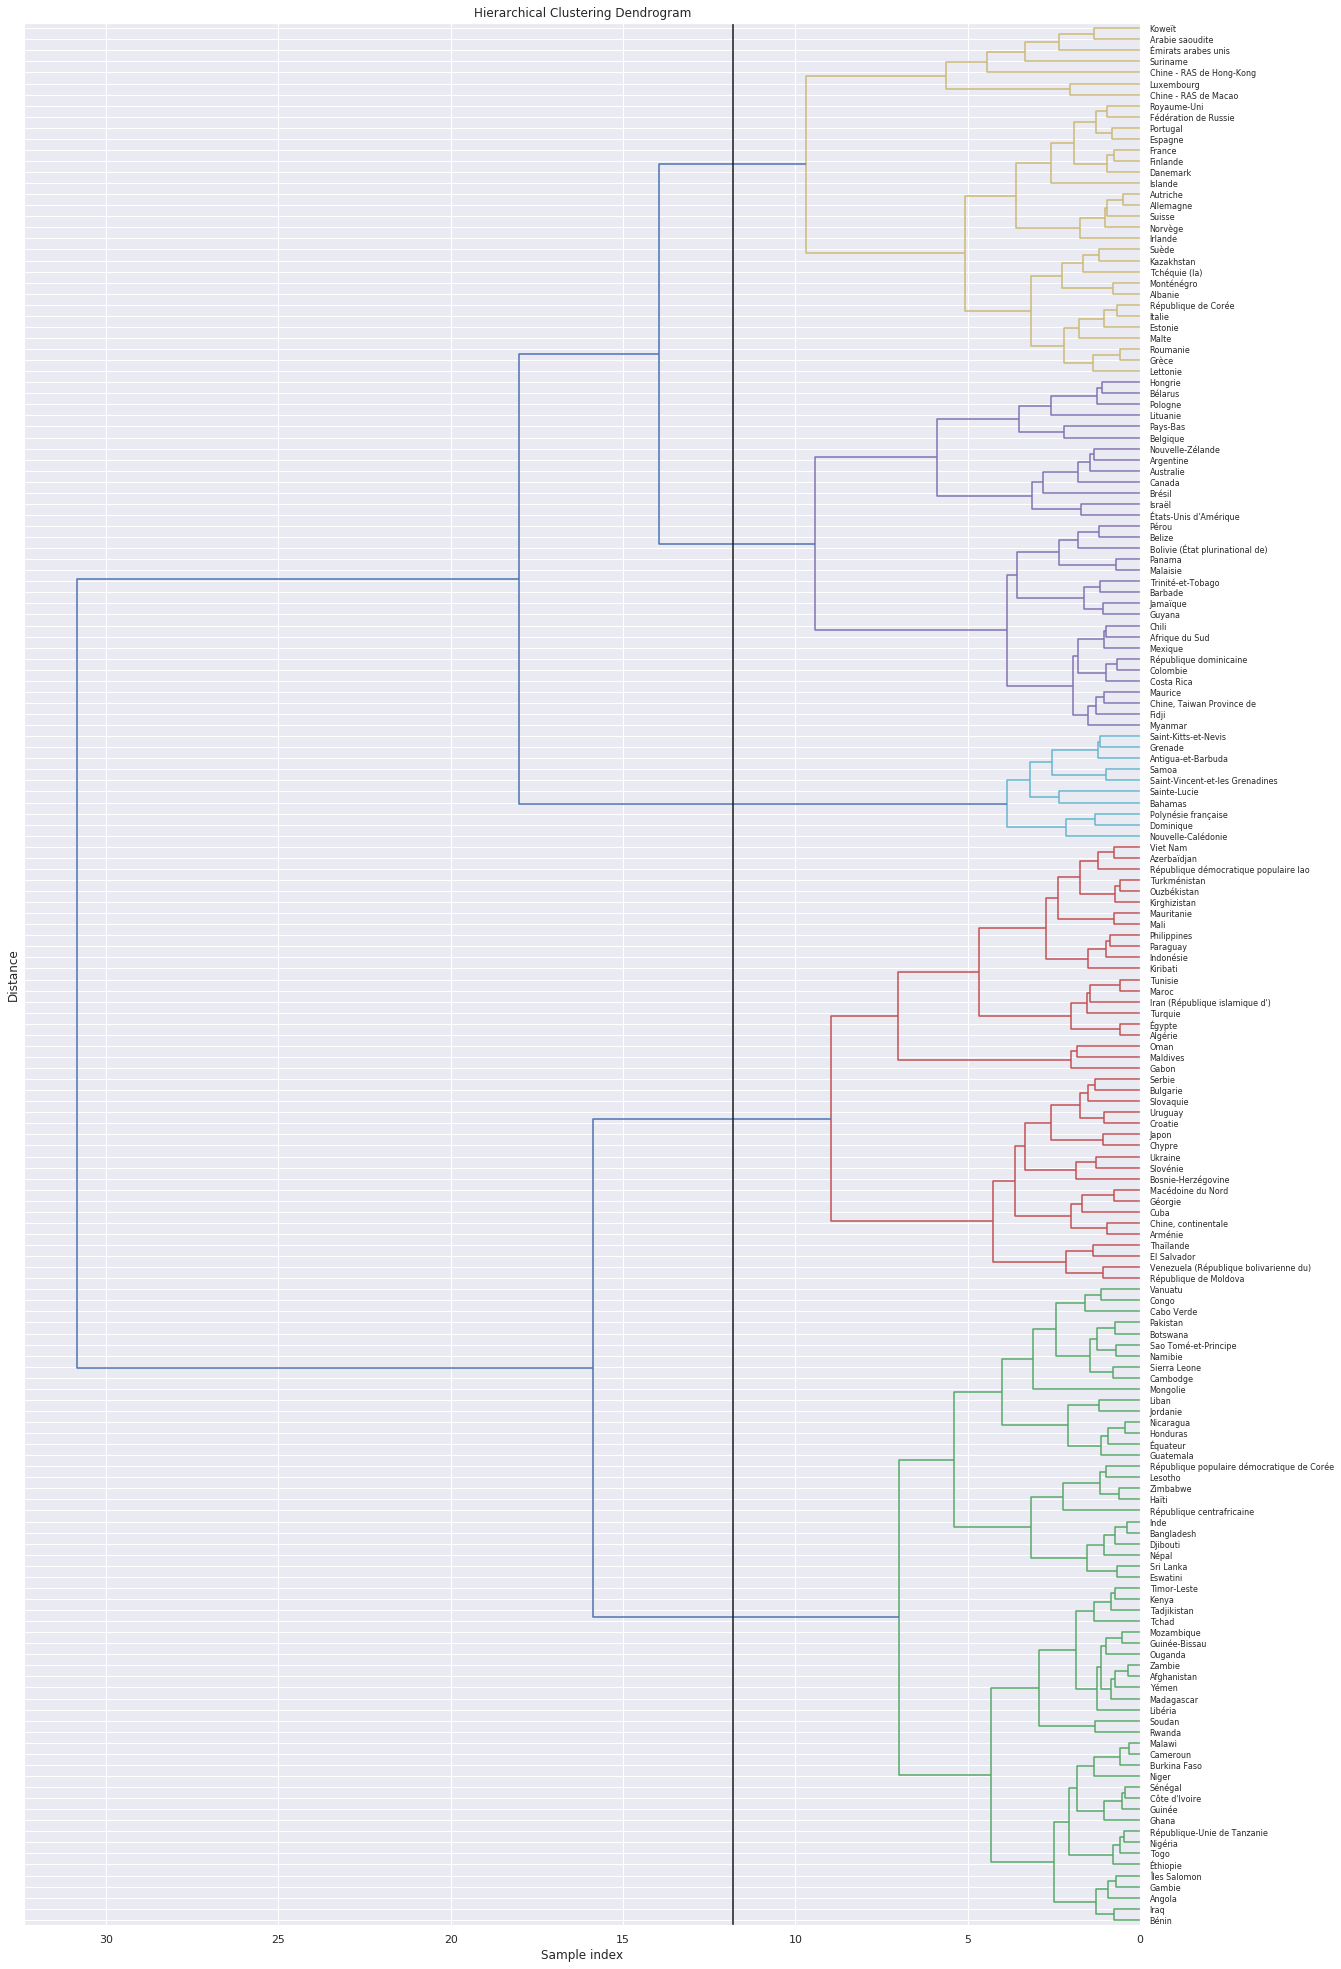

In [15]:
# Affichage du dendrogramme complet

x = Z[-__CLUSTER__][2] + (Z[-__CLUSTER__+1][2] - Z[-__CLUSTER__][2]) / 2

plt.figure(figsize=(20,35))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axvline(x, c='k')
dendrogram(
    Z,
    labels = data.index,
    orientation = "left",
    color_threshold = x,
    leaf_font_size = 8
)

plt.savefig('Images/dendrogramme.png')
plt.show()

### Affichage et calcul de centroïde

In [16]:
data.groupby(clusters).mean()

,Difference de population,Disponibilité alimentaire Kcal,Disponibilité alimentaire Protéine,Proportion Protéine Animale,Disponibilité alimentaire Kcal - volaille,Solde importation - Quantité,Production,PIB,Clusters
1,6.429673,2414.017241,61.040690,0.262106,24.12069,3.604499,4.015469,5964.632809,1
2,2.962741,2951.175000,83.767000,0.418987,52.37500,5.181673,11.077755,13506.268219,2
3,1.962696,2660.700000,81.175000,0.614681,195.10000,64.321566,5.258476,21903.819791,3
4,2.329047,3105.812500,90.036875,0.524589,136.56250,-3.180991,42.905233,25245.509839,4
5,1.773754,3369.781250,106.040312,0.577389,94.03125,10.282444,16.005833,46624.099948,5


In [17]:
data.groupby(clusters).mean().to_csv(path_or_buf='./Export/centroide.csv')

### Choix des pays

Nous allons, tout d'abord, nous intéresser au PIB. en sélectionnant les clusters dont la médiane est proche au supérieure à la médiane de l'ensemble des pays. Nous sélectionnons, ainsi, les clusters 3, 4 et 5. Les moyennes des centroïdes sont supérieures à 20000$ / habitant

Ensuite, nous allons éliminer les exportateurs nettes de volailles, c'est à dire le cluster 4. Concernant la production, le cluster 4 est un gros producteur, ainsi que pour le 5. Mais le cluster 5 reste aussi un importateur de volaille.

Enfin, nous choississons les clusters ayant une disponibilité alimentaire élevées, et donc, susceptible de consommer. Les clusters 2, 3, 4 et 5 correspondent à cette description. Les moyennes des centroïdes sont supérieures ou proche de 2500 Kcal / habitant / jour

Suite à ces critères, les clusters 3 et 5 sont les plus susceptibles de contenir des pays ayant un marché pour l'importation de poulet.

## Partie IV - Choix d'une courte liste de pays

In [18]:
data_short = data[data['Clusters'].isin([3, 5])].copy()

### Préparation des données - Centrage et Réduction

In [19]:
# préparation des données pour le clustering
X_short = data_short.values
names = data_short.index

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_short)
X_scaled = std_scale.transform(X_short)

### Analyse exploratoire

In [20]:
Z_short = linkage(X_scaled, 'ward')
clusters = fcluster(Z_short, __CLUSTER__, criterion='maxclust')

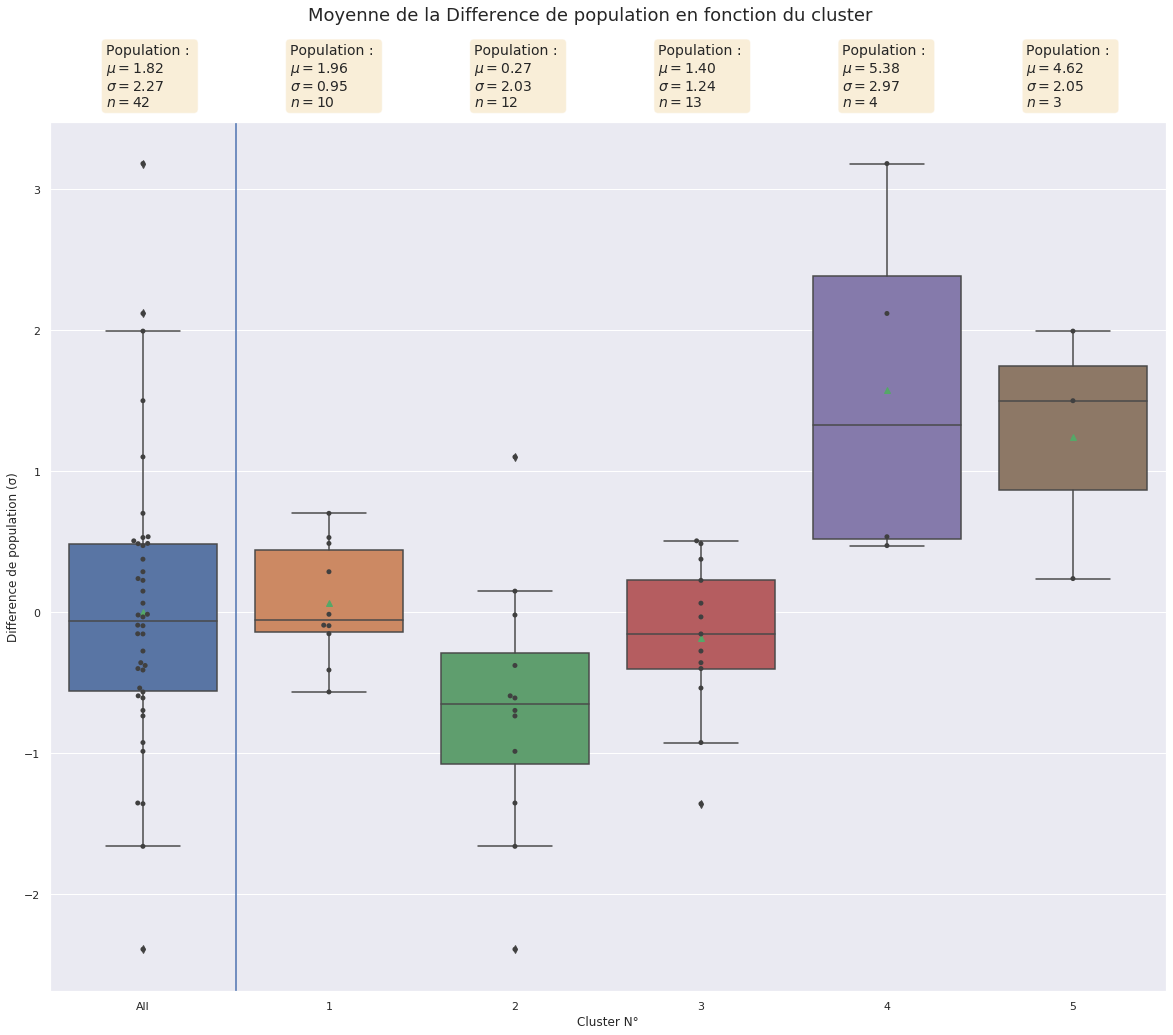

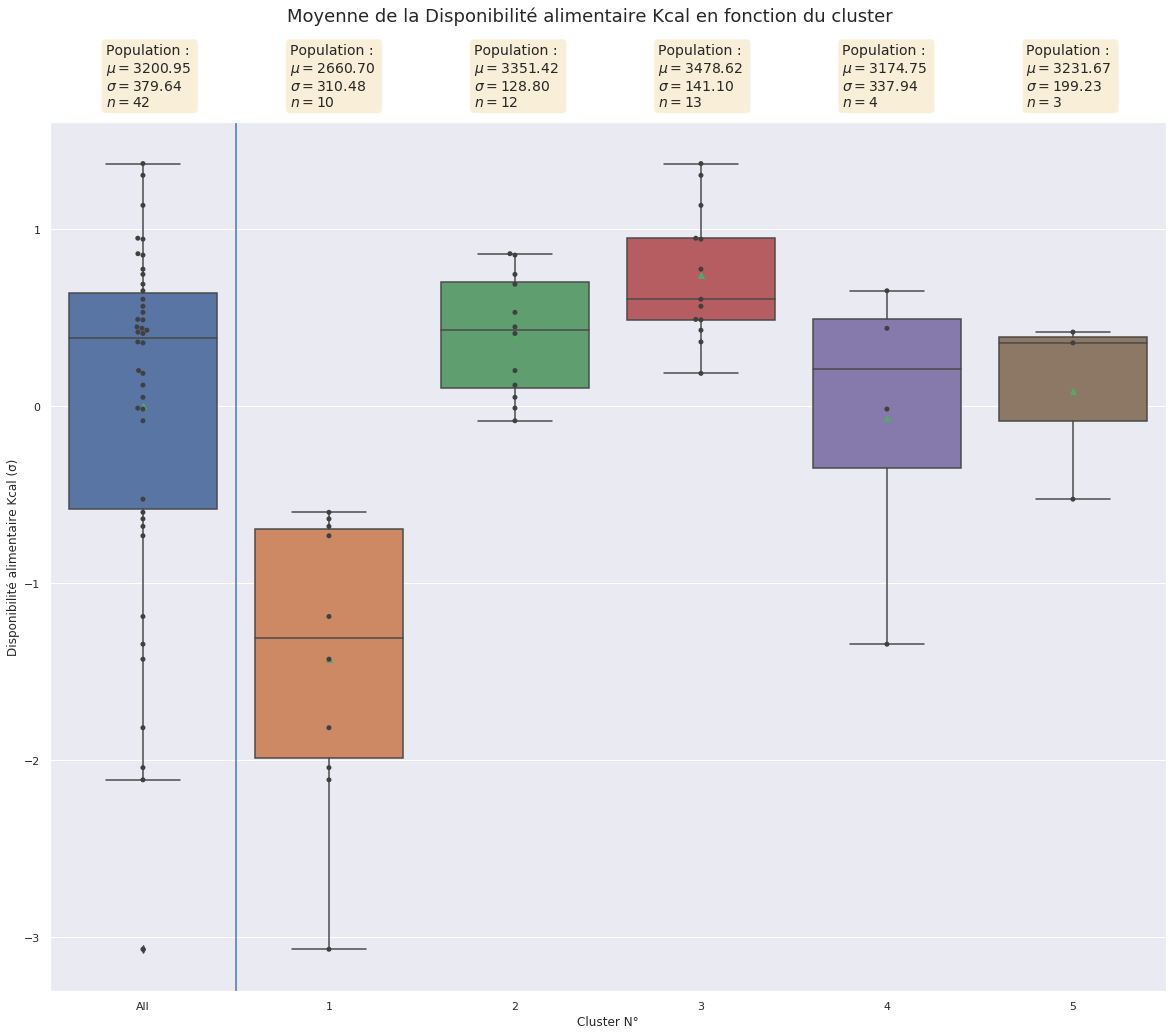

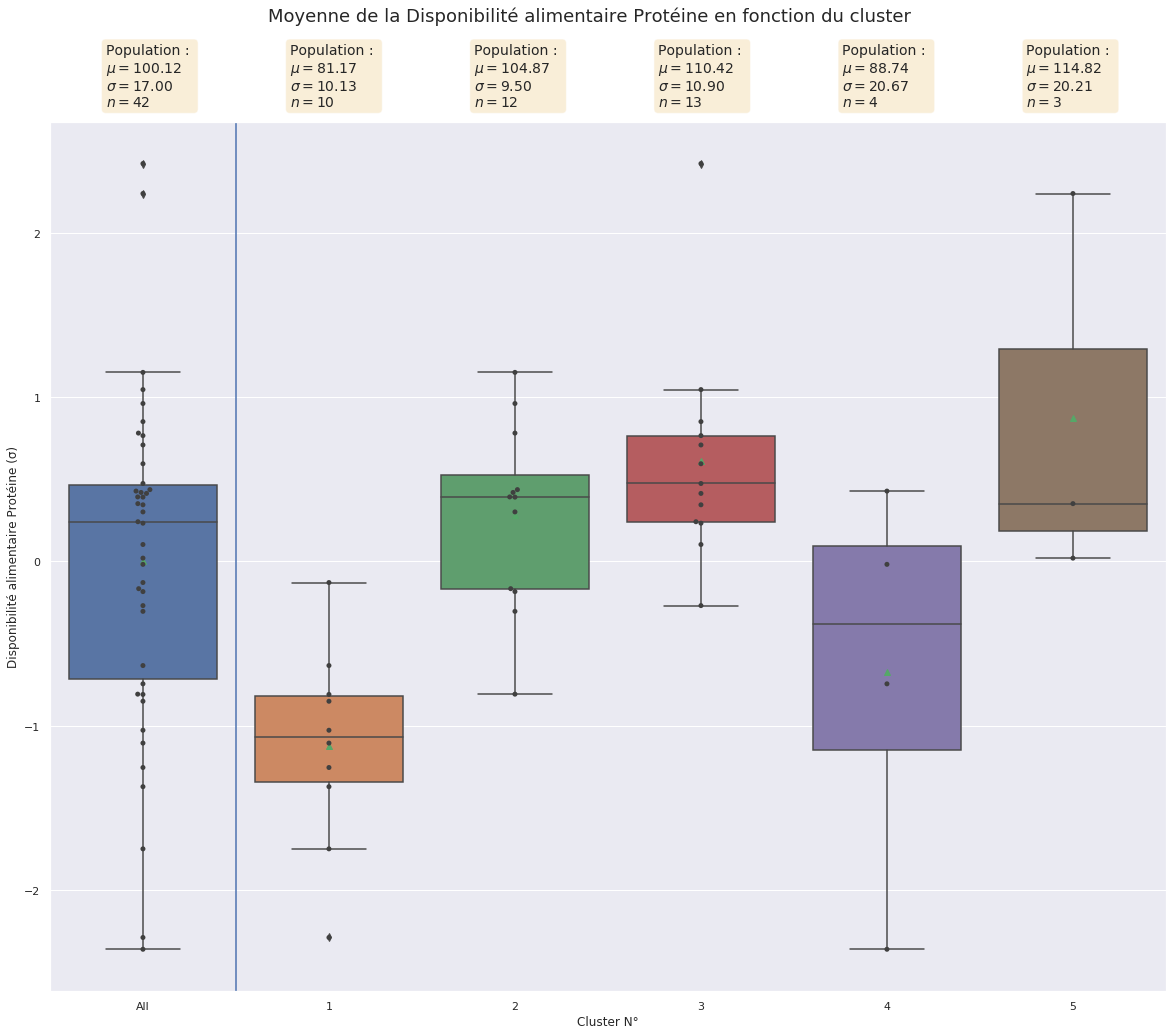

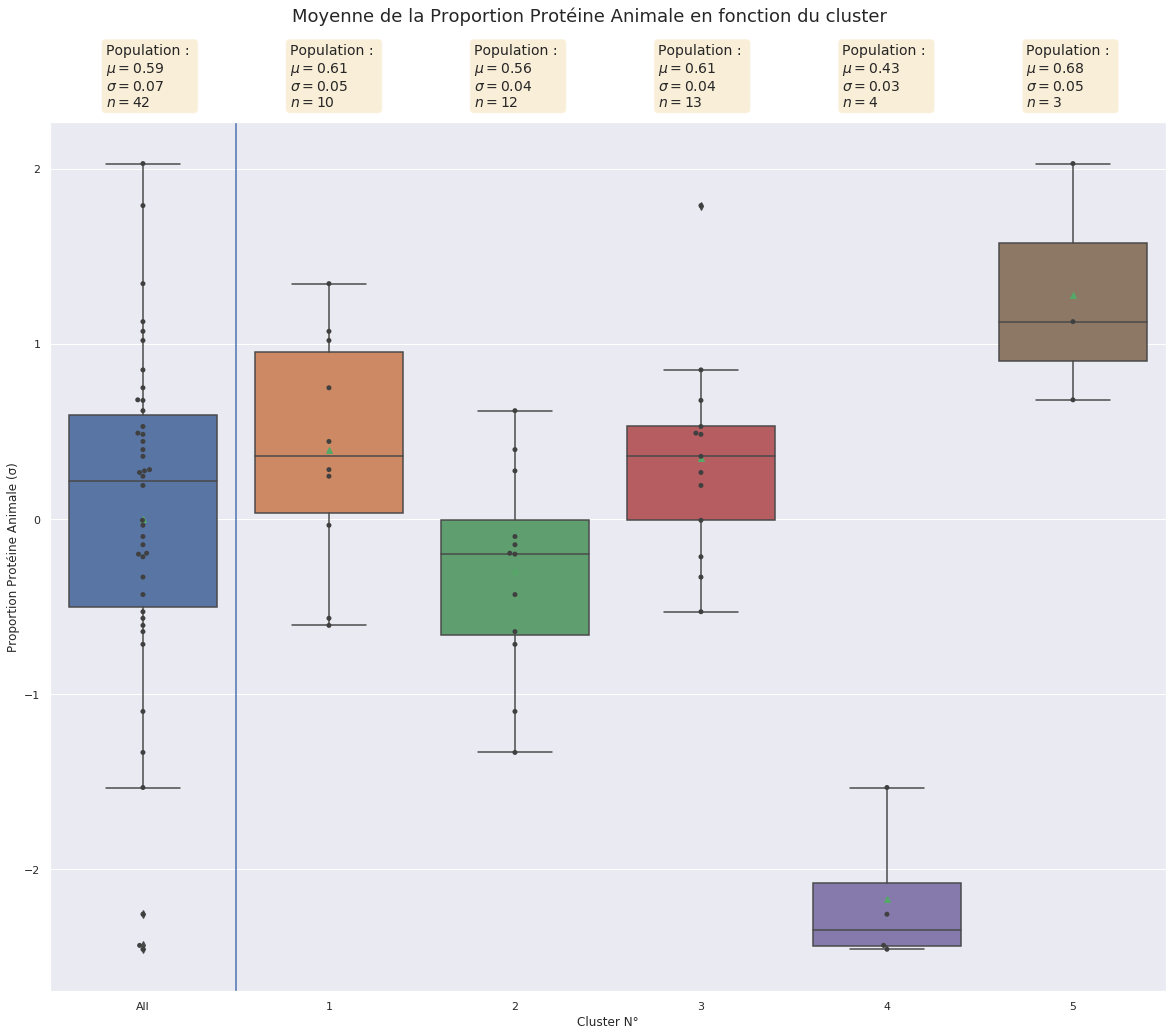

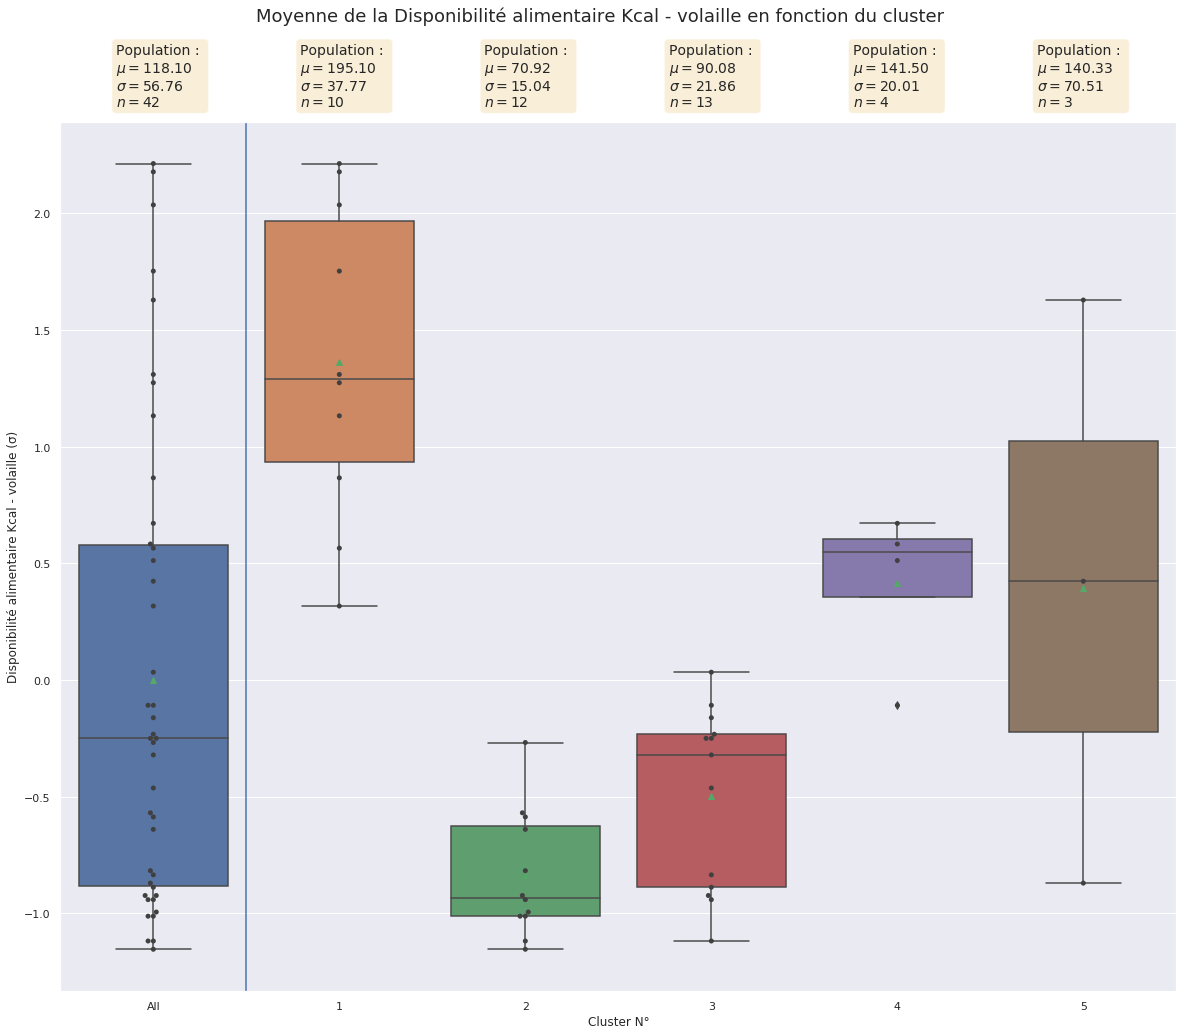

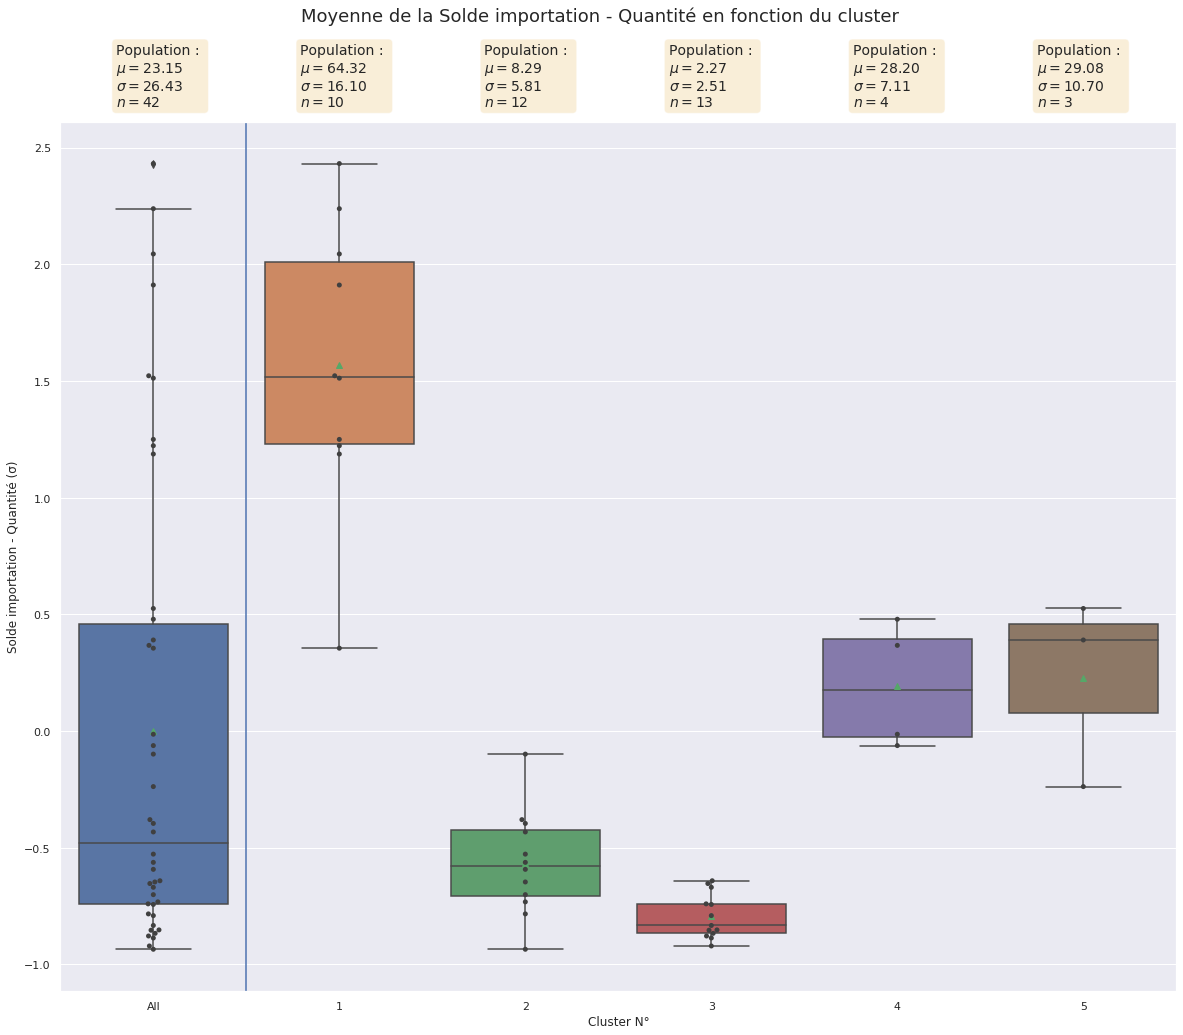

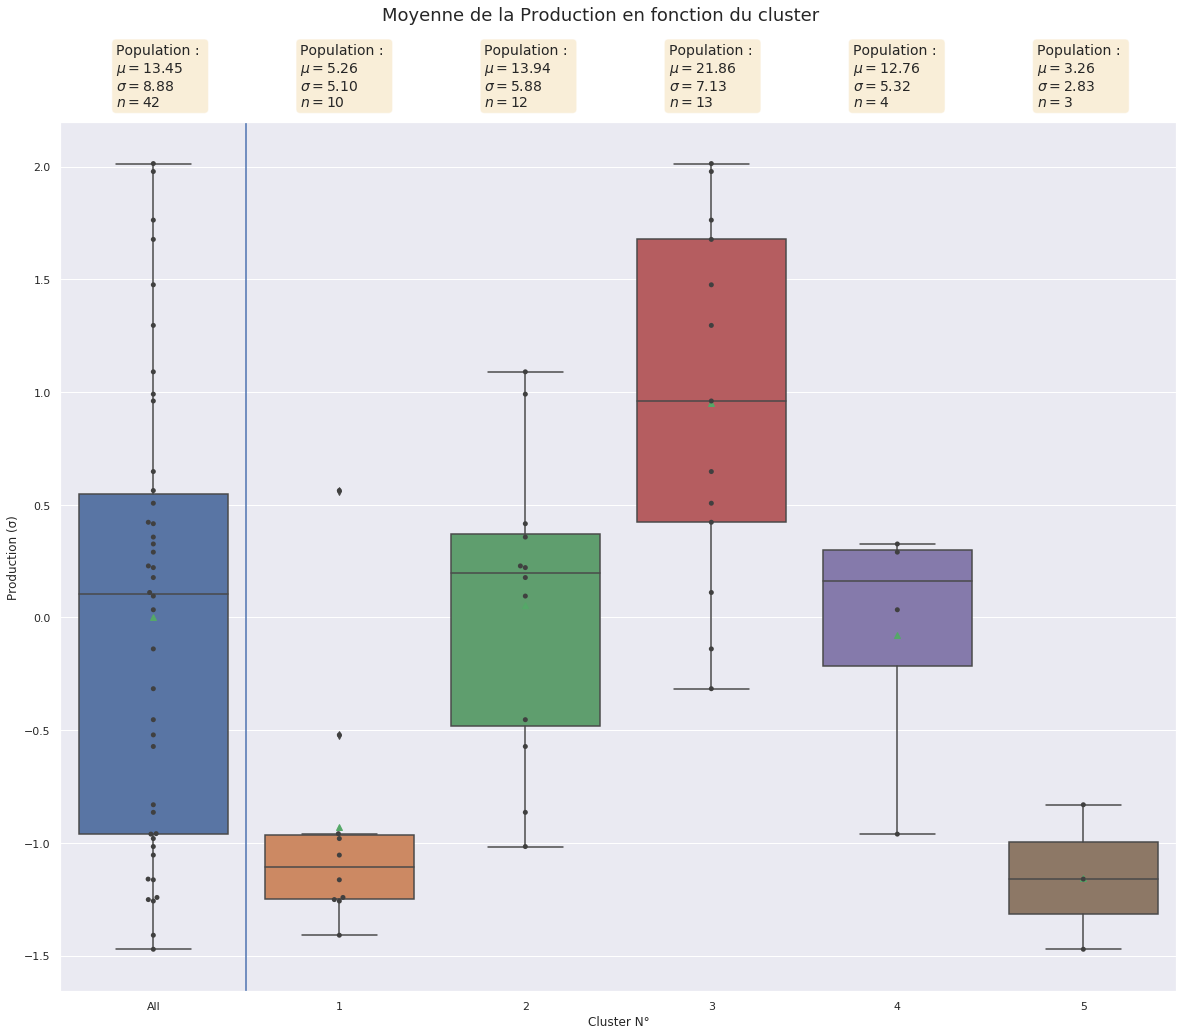

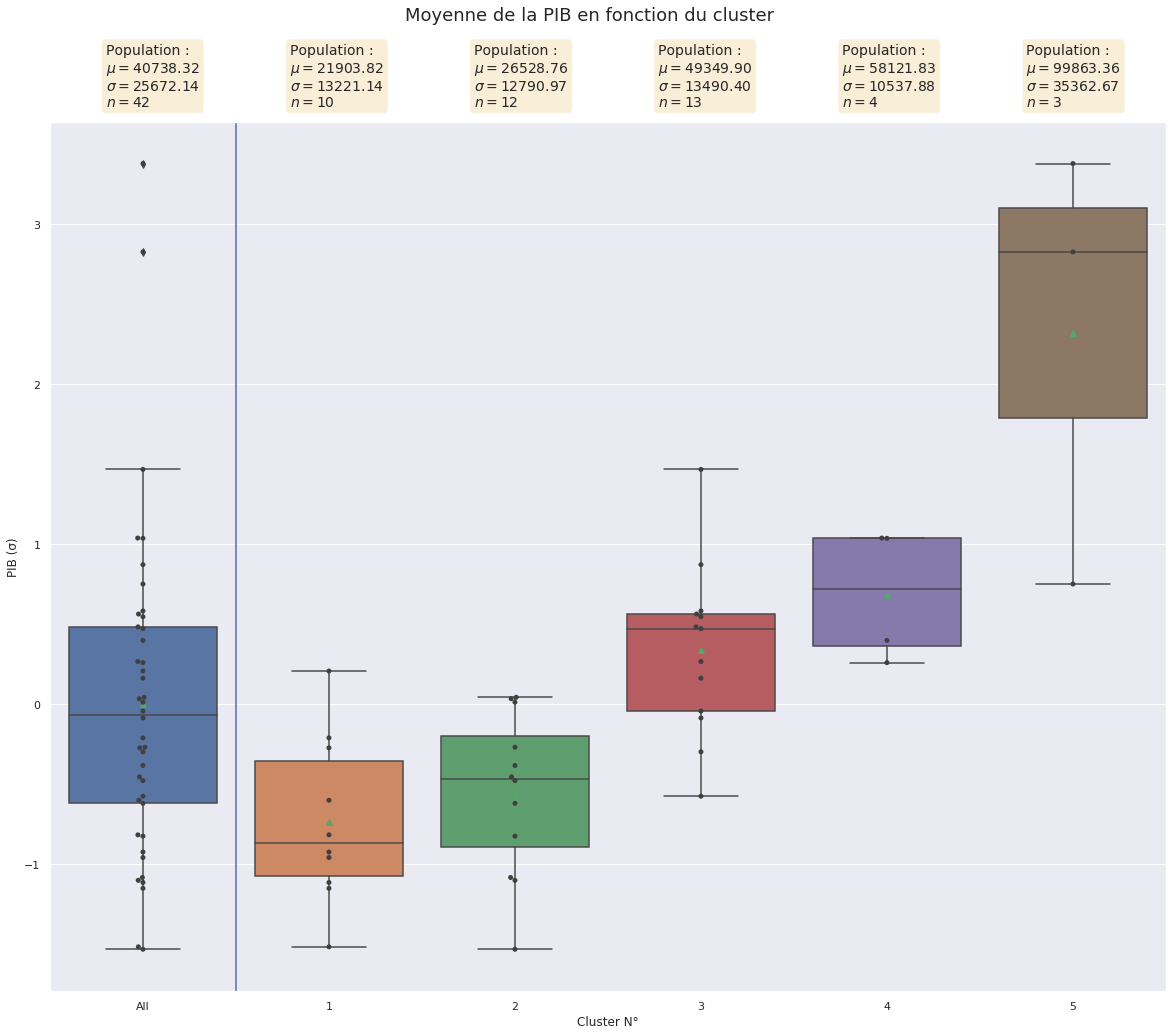

In [21]:
OCR.plotbox(data_short, clusters)

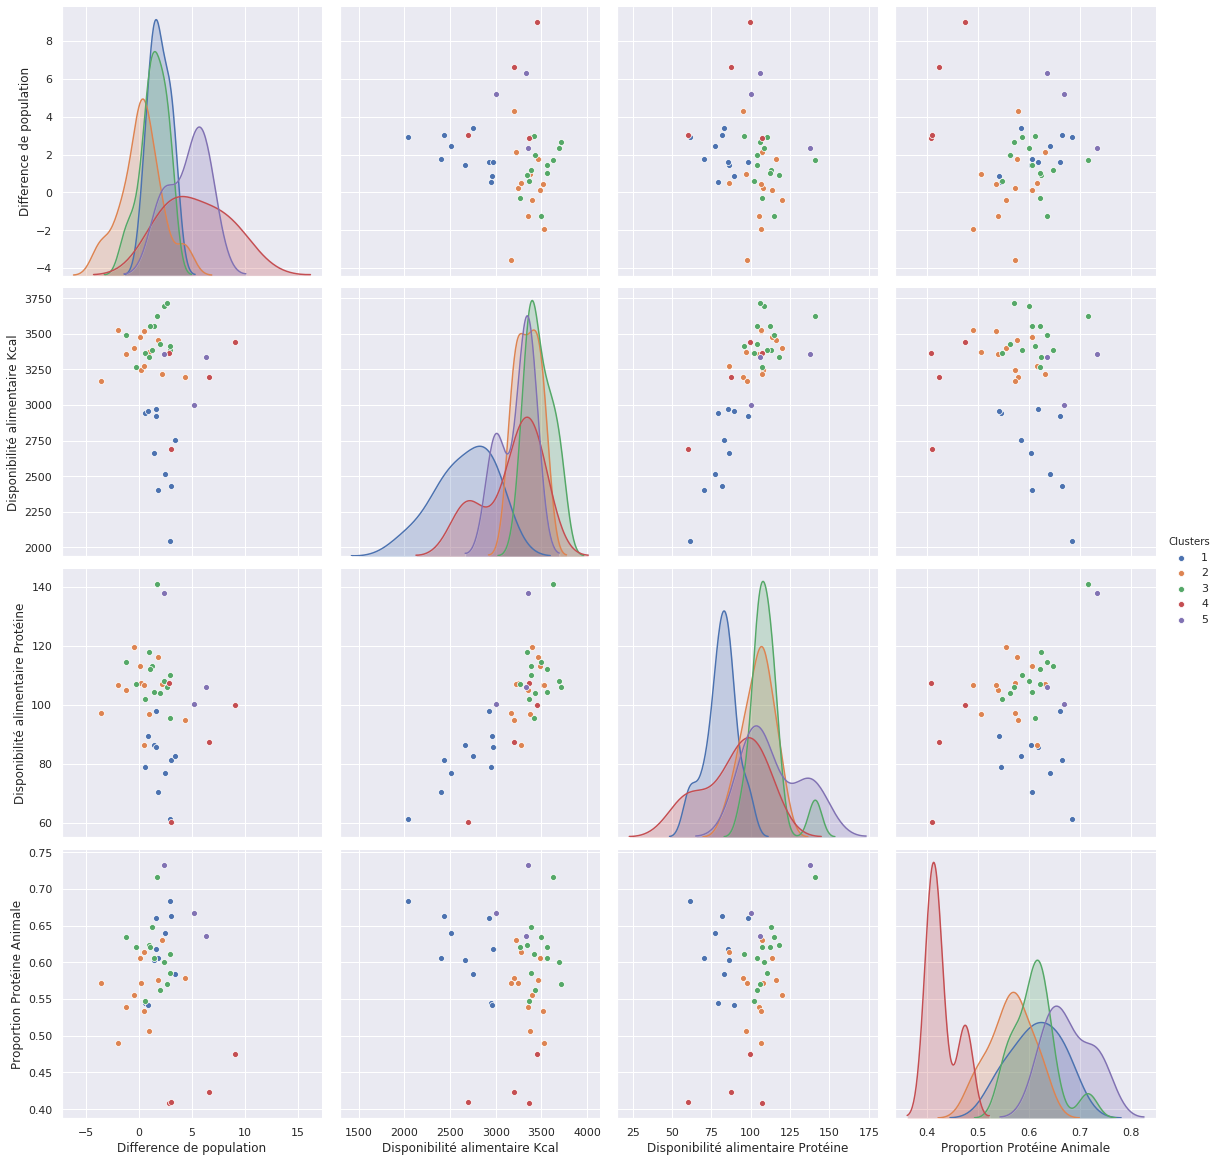

In [22]:
df_short = pd.DataFrame(data=X_short)
df_short.columns = ['Difference de population', 'Disponibilité alimentaire Kcal', 'Disponibilité alimentaire Protéine', 'Proportion Protéine Animale', 'Disponibilité alimentaire Kcal - volaille', 'Solde importation - Quantité', 'Production', 'PIB', 'Clusters']
df_short['Clusters'] = clusters
sns.pairplot(df_short[['Difference de population', 'Disponibilité alimentaire Kcal', 'Disponibilité alimentaire Protéine', 'Proportion Protéine Animale', 'Clusters']], hue='Clusters', height=4)

plt.savefig('Images/carac_paires_short.png')

### Dendrogramme

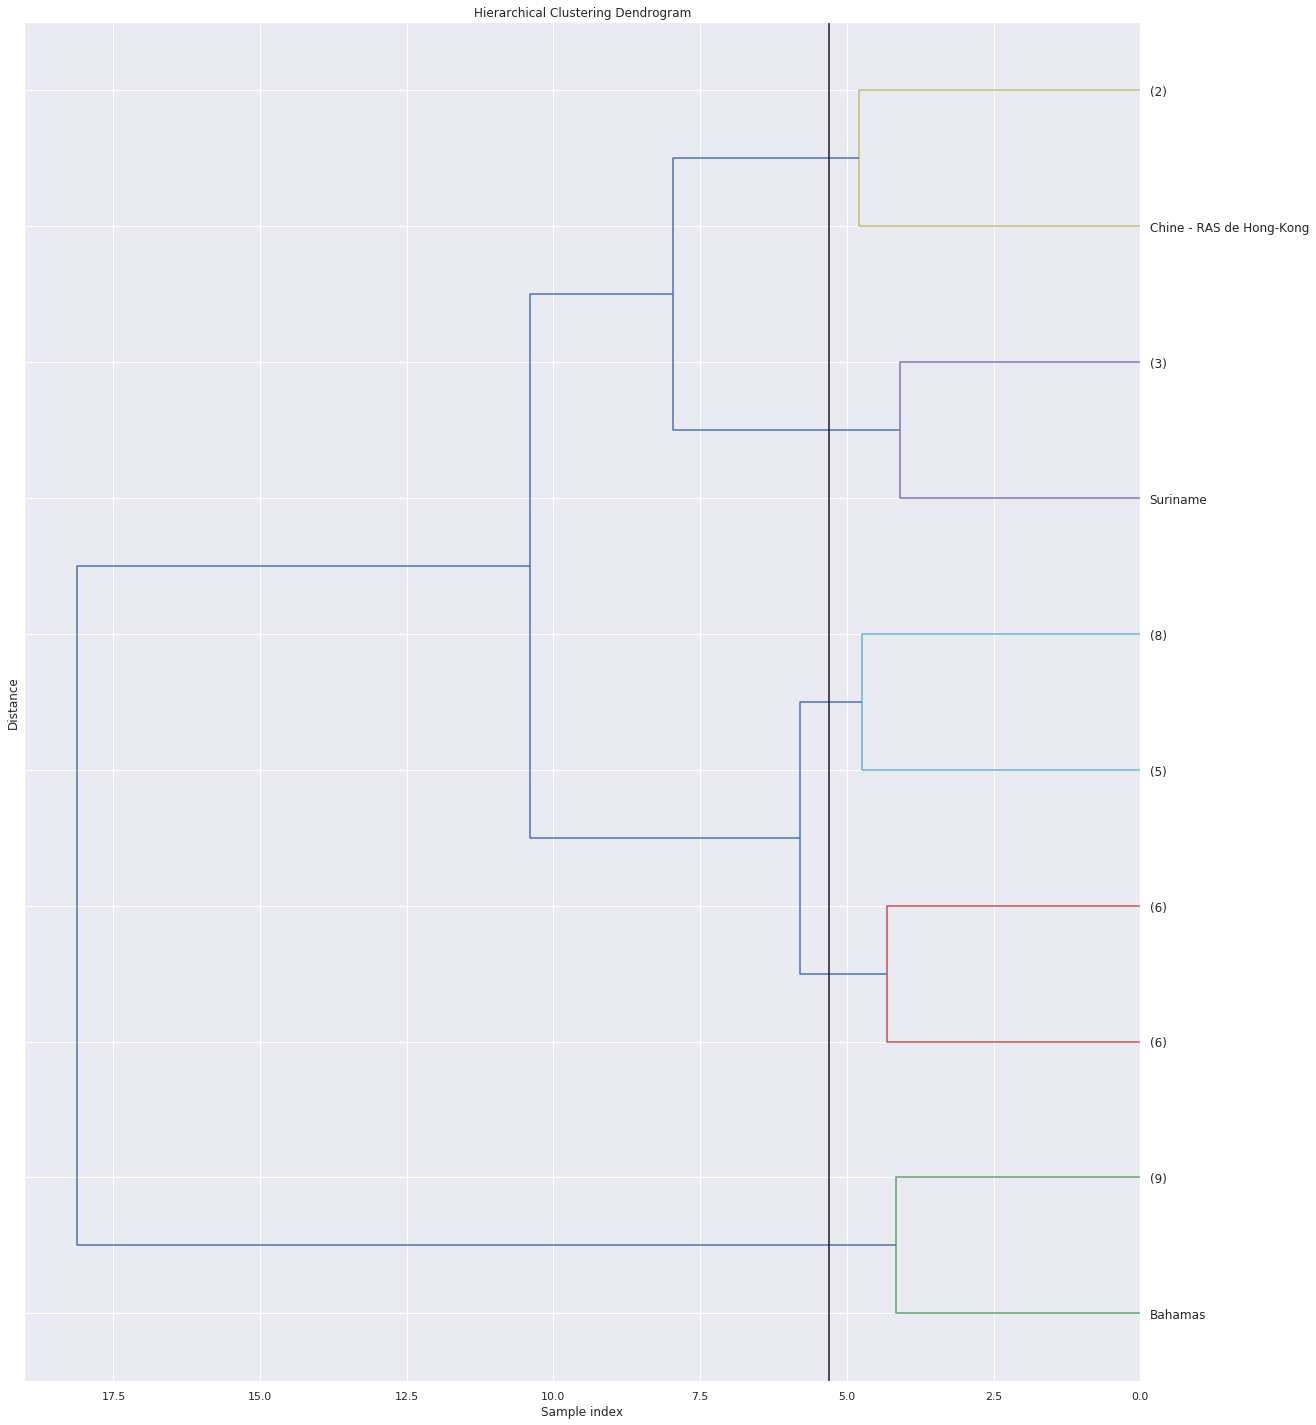

In [23]:
# Affichage du dendrogramme tronqué

x = Z_short[-__CLUSTER__][2] + (Z_short[-__CLUSTER__+1][2] - Z_short[-__CLUSTER__][2]) / 2

plt.figure(figsize=(20,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axvline(x, c='k')
dendrogram(
    Z_short,
    labels = data_short.index,
    orientation = "left",
    color_threshold = x,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10
)
plt.show()

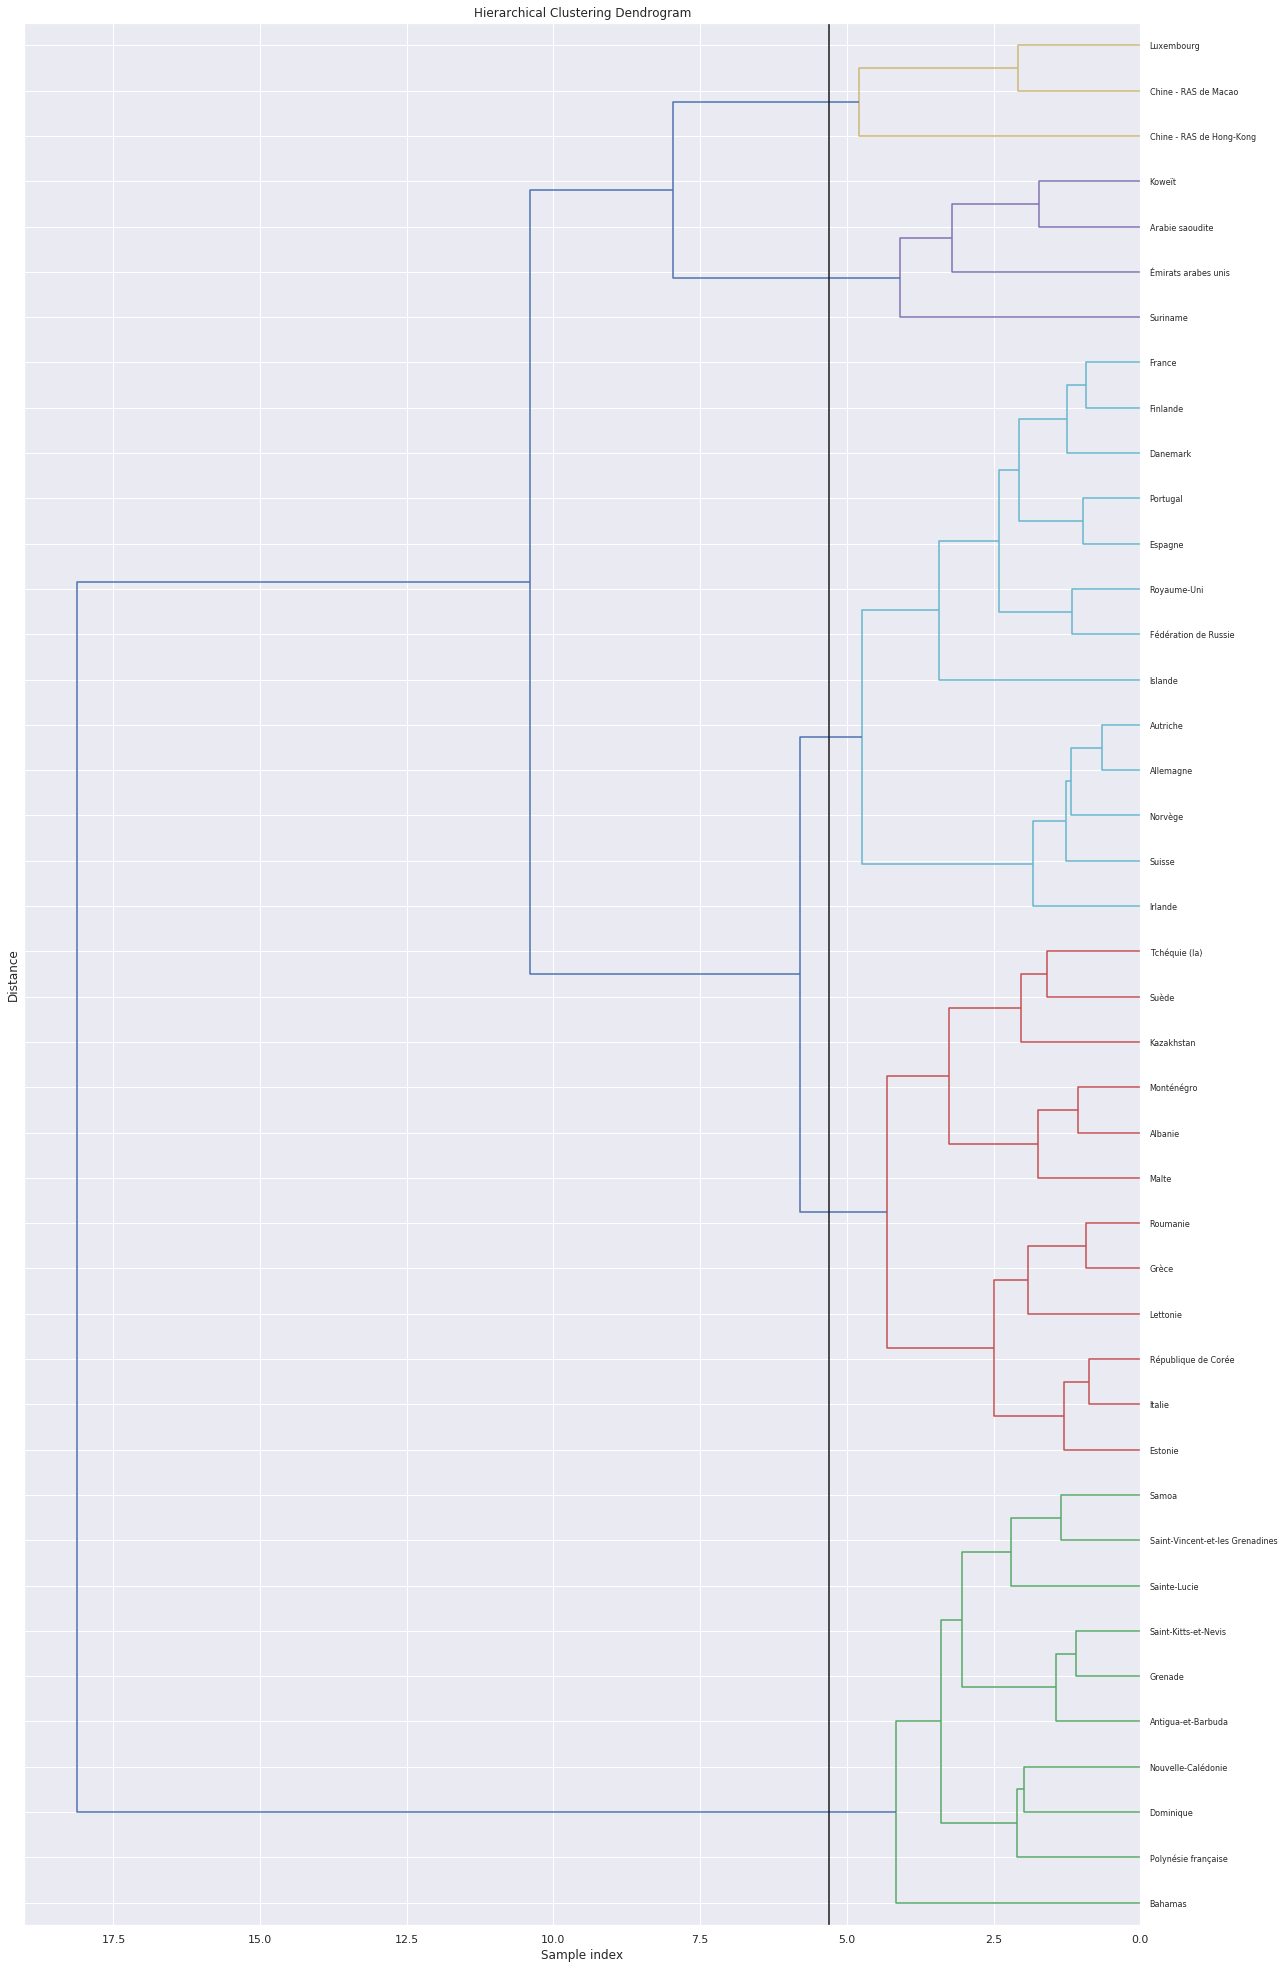

<Figure size 432x288 with 0 Axes>

In [24]:
# Affichage du dendrogramme complet

x = Z_short[-__CLUSTER__][2] + (Z_short[-__CLUSTER__+1][2] - Z_short[-__CLUSTER__][2]) / 2

plt.figure(figsize=(20,35))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.axvline(x, c='k')
dendrogram(
    Z_short,
    labels = data_short.index,
    orientation = "left",
    color_threshold = x,
    leaf_font_size = 8
)
plt.show()

plt.savefig('Images/dendrogramme_short.png')

### Affichage et calcul de centroïde

In [25]:
data_short.groupby(clusters).mean()

,Difference de population,Disponibilité alimentaire Kcal,Disponibilité alimentaire Protéine,Proportion Protéine Animale,Disponibilité alimentaire Kcal - volaille,Solde importation - Quantité,Production,PIB,Clusters
1,1.962696,2660.700000,81.175000,0.614681,195.100000,64.321566,5.258476,21903.819791,1
2,0.270744,3351.416667,104.868333,0.564573,70.916667,8.287589,13.935827,26528.758491,2
3,1.395668,3478.615385,110.419231,0.611484,90.076923,2.271936,21.857788,49349.901143,3
4,5.375119,3174.750000,88.742500,0.429029,141.500000,28.204827,12.758191,58121.825261,4
5,4.622343,3231.666667,114.816667,0.678726,140.333333,29.077552,3.257571,99863.360175,5


In [26]:
data.groupby(clusters).mean().to_csv(path_or_buf='./Export/centroide.csv')

ValueError: Grouper and axis must be same length

### Choix final des pays

Sur les 5 clusters, il n'y a pas d'exporteur nettes de volailles. Concernant la production, le cluster 1, 4 et 5 ne sont pas de gros producteur, mais également, ils sont de gros importateur de volailles, et de gros consommateur de volailles, en regard de leur disponibilité alimentaire en volailles.

Enfin, nous choississons les clusters ayant une disponibilité alimentaire élevées parmi les clusters 1, 4 et 5, et donc, susceptible de consommer. Le clusters 4 et 5 correspondent à cette description. La moyenne du centroïdes est supérieure à 3000 Kcal / habitant / jour

Suite à ces critères, le clusters 4 et 5 sont le plus intéressant pour un marché pour l'importation de poulet. Soit 7 pays :

In [ ]:
data_short[data_short['Clusters'].isin([4, 5])]

## Partie V - Réalisation du ACP

In [ ]:
fig, axes = plt.subplots(figsize = (20, 10))

# choix du nombre de composantes à calculer
n_comp = 7

# selection des colonnes à prendre en compte dans l'ACP

data_pca = df[['Difference de population', 'Disponibilité alimentaire Kcal', 'Disponibilité alimentaire Protéine', 'Proportion Protéine Animale', 'Disponibilité alimentaire Kcal - volaille', 'Solde importation - Quantité', 'Production', 'PIB']]

# préparation des données pour l'ACP
X = data_pca.values
names = df.index #pour avoir les intitulés
features = df.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
OCR.display_scree_plot(pca)

plt.show()

In [ ]:
# Cercle des corrélations
pcs = pca.components_
OCR.display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
OCR.display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], df['Clusters'])#, labels = np.array(names))

In [ ]:
for i in (1,5):
    for j in range(0, len(df.columns)-1):
        stat, p = shapiro(df[df['Clusters'] == i].iloc[:, j])
        print('Test de normalité pour le cluster', i, 'et la colonne', df.columns[j])
        print('stat=%.3f, p=%.3f' % (stat, p))
        
        fig, axes = plt.subplots(figsize = (20, 10))
        plt.hist(df[df['Clusters'] == i].iloc[:, j])
        plt.show()
        
        fig, axes = plt.subplots(figsize = (20, 10))
        qqplot(df[df['Clusters'] == i].iloc[:, j], line='s')
        plt.show()
        
        if p > 0.05:
            print('Probably Gaussian\n\n')
        else:
            print('Probably not Gaussian\n\n')

Nouc constatons que seulement 4 variables sont probablement gaussienne, les variables Disponibilité alimentaire Kcal, Disponibilité alimentaire Protéine, Proportion Protéine Animale, Production

### Test de comparaison de deux populations (dans le cas gaussien) 

In [ ]:
data1 = data.loc[data['Clusters'] == 3, 'Disponibilité alimentaire Kcal']
data2 = data.loc[data['Clusters'] == 5, 'Disponibilité alimentaire Kcal']

fig, axes = plt.subplots(figsize = (20, 10))

data1.hist()
data2.hist()

plt.show()

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

In [ ]:
data1 = data.loc[data['Clusters'] == 3, 'Proportion Protéine Animale']
data2 = data.loc[data['Clusters'] == 5, 'Proportion Protéine Animale']

fig, axes = plt.subplots(figsize = (20, 10))
data1.hist()
plt.show()
                
fig, axes = plt.subplots(figsize = (20, 10))
data2.hist()
plt.show()

stat, p = ttest_ind(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')